In [1]:
# %matplotlib widget
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
import json
from scipy.fft import fft, fftfreq

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Could not import QickSoc: No module named 'pynq'


c:\ProgramData\Anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


# Load experiments

In [3]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas
import experiments.fitting as fitter

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.DONOTUSE_ramsey_ef
imported experiments.single_qubit.DONOTUSE_randbench
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.adiabatic_pulse_calib
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.length_rabi_EgGf
imported e

Set save data

In [4]:
save_data = True

In [5]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [6]:
# expt_path=os.getcwd()+'\data\data_220623'
# expt_path=os.getcwd()+'\data\data_220712'
# expt_path=os.getcwd()+'\data\data_220801'
# expt_path=os.getcwd()+'\data\data_220904'
# expt_path=os.getcwd()+'\data\data_220919'
# expt_path=os.getcwd()+'\data\data_220929'
# expt_path=os.getcwd()+'\data\data_221007'
# expt_path=os.getcwd()+'\data\data_221020'
# expt_path=os.getcwd()+'\data\data_221215'
# expt_path=os.getcwd()+'\data\data_230217'
# expt_path=os.getcwd()+'\data\data_230707'
expt_path=os.getcwd()+'\data\data_230927'
print('Data will be stored in', expt_path)

Data will be stored in s:\Connie\experiments\qramLL_4QR2\data\data_230927


In [7]:
# config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond.yml'
# config_file = 'config_q3diamond_full688_reset.yml'
config_file = 'config_q3diamond_full688and638_reset.yml'
config_path = os.getcwd() + '\\' + config_file
print('Config will be', config_path)

Config will be s:\Connie\experiments\qramLL_4QR2\config_q3diamond_full688and638_reset.yml


Load config

In [8]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

# Qubit/resonator to probe

In [9]:
all_results = [dict(), dict(), dict(), dict()]
saved_files = []

In [10]:
qubit_i = 3
results_Qi = all_results[qubit_i]

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [11]:
# im = InstrumentManager(ns_address='192.168.14.1') # Chicago lab
# im = InstrumentManager(ns_address='192.168.137.1') # SLAC lab
im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium

In [24]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# # TURN OFF
# lo1.set_standby(True)
# lo1.set_output_state(False)

# TURN ON
lo1.set_standby(False)
lo1.set_output_state(True)
lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
lo_power = float(yaml_cfg.hw.lo.readout.power)
lo1.set_frequency(lo_freq) # Set LO frequency
print(f'set freq to [MHz] {lo_freq*1e-6}')
lo1.set_power(lo_power) # Set LO power
print('set power to', lo_power)

Default Instrument SC_26C1
set freq to [MHz] 5925.0
set power to 7.0


In [12]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())

# soc = QickConfig(im['Qick187'].get_cfg())


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 0, envelope memory 65536 samples
		DAC tile 2, ch 0, 32-bit DDS, fabric=399.360 MHz, fs=6389.760 MHz
	1:	axis_signal_gen_v6 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, ch 1, 32-bit DDS, fabric=399.360 MHz, fs=6389.760 MHz
	2:	axis_signal_gen_v6 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, ch 2, 32-bit DDS, fabric=399.360 MHz, fs=6389.760 MHz
	3:	axis_signal_gen_v6 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, ch 3, 32-bit DDS, fabric=399.360 MHz, fs=6389.760 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 3, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	5:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	6:	axis_sg_mux4_v2 - tProc output

In [14]:
# print(list(im))
# print(im)

# RFSoC Calibration

In [18]:
tof = meas.ToFCalibrationExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"adc_trig_offset_calibration_qubit{qubit_i}",
    config_file=config_path,
)

tof.cfg.expt = dict(
    pulse_length=0.5, # [us]
    readout_length=1.0, # [us]
    trig_offset=0, # [clock ticks]
    # gain=32000,
    gain=1.0, # [MUX units: -1 to 1]
    frequency=tof.cfg.device.readout.frequency[qubit_i], # [MHz]
    reps=1000, # Number of averages per point
    # qubit=qubit_i,
    qubit=qubit_i,
)
tof.cfg.device.readout.relax_delay=0.1 # wait time between experiments [us]
# print(tof.cfg)

import Pyro4.util
try:
    tof.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

215 307
readout freq 950 +/- -815.202041072


  0%|          | 0/1000 [00:00<?, ?it/s]

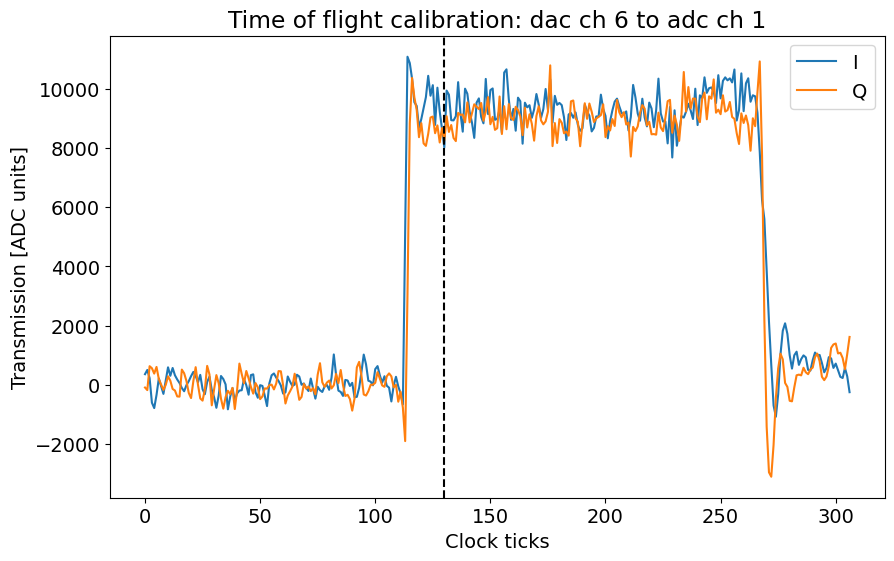

In [19]:
tof.display(adc_trig_offset=130)

# Initial single tone resonator spectroscopy

In [13]:
rspec = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
rspec.cfg = AttrDict(deepcopy(yaml_cfg))

span = 2.0 # MHz
npts = 250
rspec.cfg.expt = dict(
    start=rspec.cfg.device.readout.frequency[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=2000,
    pulse_e=False, # add ge pi pulse prior to measurement
    pulse_f=False, # add ef pi pulse prior to measurement
    qubit=qubit_i,
)
# rspec.cfg.device.readout.gain[qubit_i] = 0.850
rspec.cfg.device.readout.relax_delay = 5 # Wait time between experiments [us]

import Pyro4.util
try:
    rspec.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/250 [00:00<?, ?it/s]

[91.11533333333333, 5000, 1000, 0, 17.123608649970073, 27.427832058098023, 0.4669933262388997]
[ 9.13789144e+01  4.53419609e+02  1.59990329e+04 -4.95138941e-01
  5.43831665e+02  1.45933882e+01 -1.71024159e-01]
5925.0
950
91.37891439370742

Freq with minimum transmission: 91.36733333333333
Freq with maximum transmission: 91.75933333333333
From fit:
	f0: 6966.378914393707
	Qi: 453.4196092183028
	Qe: 15999.03293280966
	Q0: 440.9236399092592
	kappa [MHz]: 15.799513303091137
	phi [radians]: -0.49513894127769914


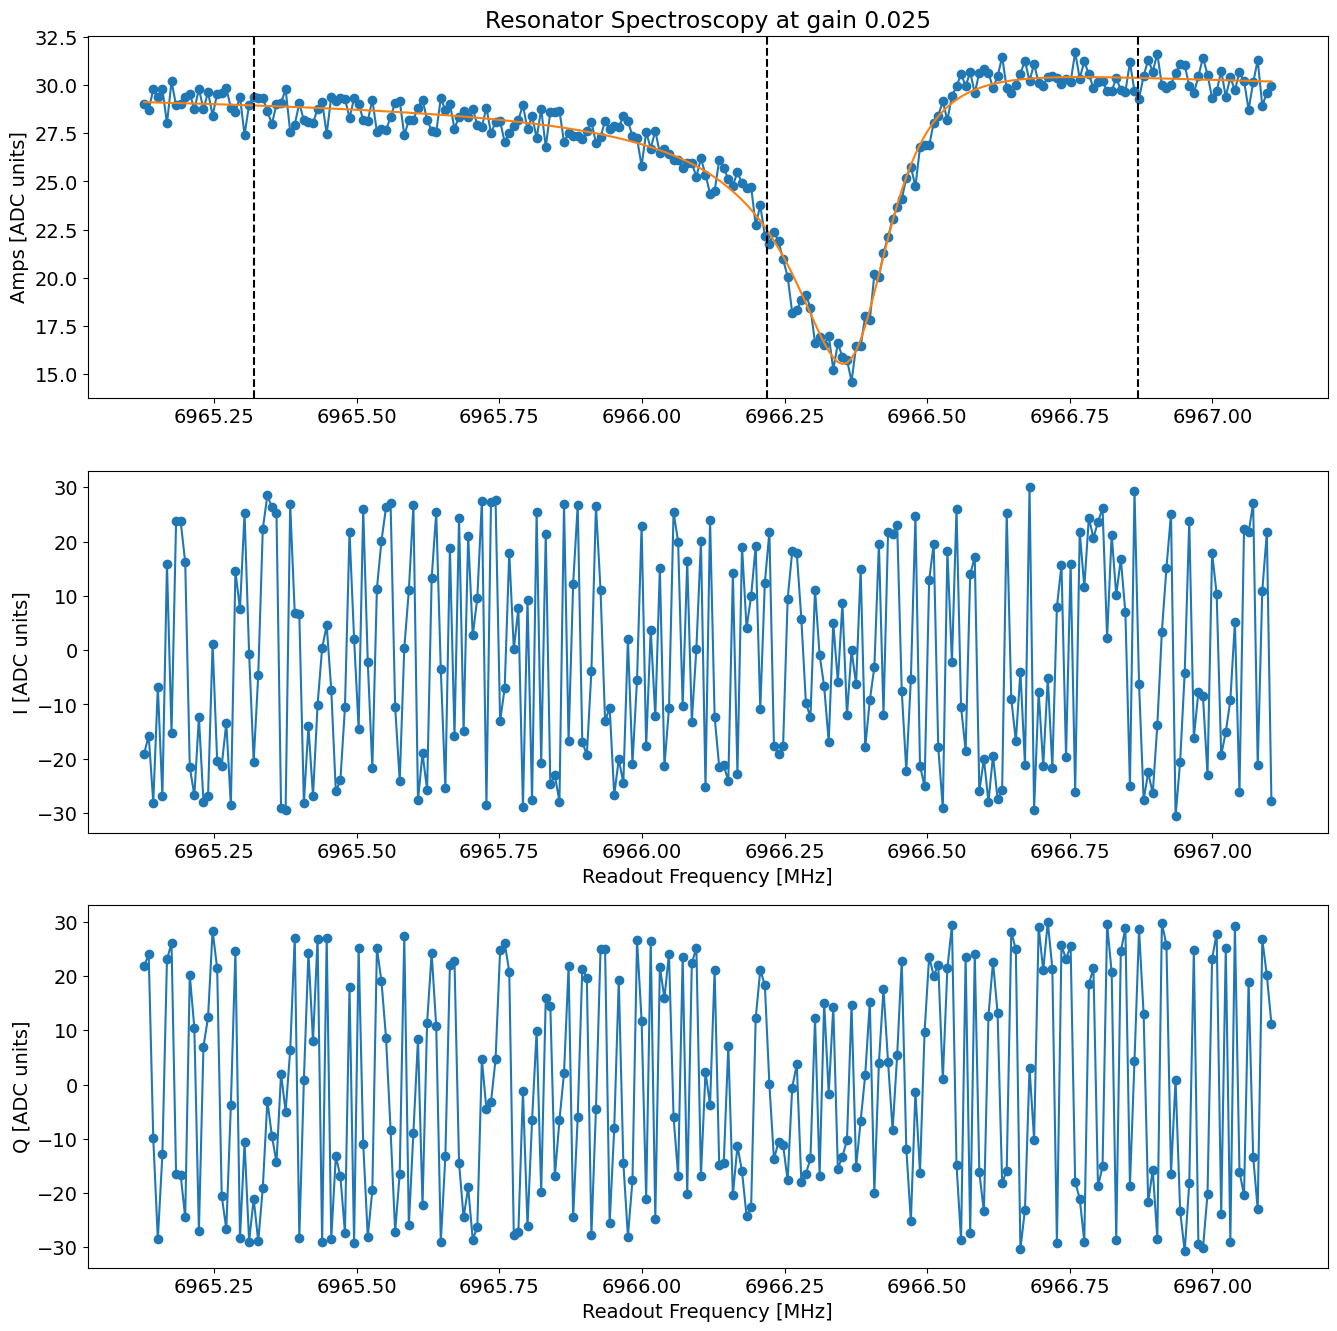

*Set cfg res 3 freq to 91.36733333333333*
*Set cfg res 3 gain to 0.025*
{'Res freq': 6966.367333333334, 'Res kappa': 0.20724430745539735}


In [14]:
# TESTING
# # rspec = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# temp_data, attrs = prev_data(expt_path, '00001_resonator_spectroscopy_qubit2.h5')
# rspec.data = temp_data

rspec.analyze(fit=True)
rspec_fit = rspec.data['fit']
# if not isinstance(rspec_fit, (list, np.ndarray)):
#     rspec.display(fit=False)
#     assert False, 'Fit failed, please manually fix!'
rspec.display(fit=True)
# yaml_cfg.device.readout.frequency[qubit_i] = rspec_fit[0]

yaml_cfg.device.readout.frequency[qubit_i] = rspec.data['xpts'][np.argmin(rspec.data['amps'])]
# yaml_cfg.device.readout.frequency[qubit_i] = rspec.data['xpts'][np.argmax(rspec.data['amps'])]

yaml_cfg.device.readout.gain[qubit_i] = rspec.cfg.device.readout.gain[qubit_i]
print(f'*Set cfg res {qubit_i} freq to {yaml_cfg.device.readout.frequency[qubit_i]}*')
print(f'*Set cfg res {qubit_i} gain to {yaml_cfg.device.readout.gain[qubit_i]}*')
results_Qi.update({'Res freq':float(yaml_cfg.hw.lo.readout.frequency)*1e-6 + yaml_cfg.device.readout.lo_sideband[qubit_i]*(yaml_cfg.device.readout.frequency[qubit_i] + yaml_cfg.hw.soc.dacs.readout.mixer_freq)})
results_Qi.update({'Res kappa':abs(rspec_fit[0]*(1/rspec_fit[1] + 1/rspec_fit[2]))})
print(results_Qi)

In [45]:
if save_data: saved_files.append(rspec.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230927\00001_resonator_spectroscopy_qubit0.h5


# Qubit ge spectroscopy

## Pulse Probe (qubit) spectroscopy

In [67]:
qspec = meas.PulseProbeSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qspec.cfg = AttrDict(deepcopy(yaml_cfg))

span = 50
npts = 300

qspec.cfg.expt = dict(
    start=qspec.cfg.device.qubit.f_ge[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=100, # Number of averages per point
    rounds=20, # Number of start to finish sweeps to average over
    length=1, # Qubit probe constant pulse length [us]
    gain=int(yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]/5), # Qubit pulse gain
    pulse_type='gauss',
    qubit=qubit_i,
)
qspec.cfg.device.readout.relax_delay = 10 # Wait time between experiments [us]
qspec.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/20 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4780.411006069921, HWHM 1.9250973899210735
Found peak in I at [MHz] 4761.725493844869, HWHM -2.442849058620359
Found peak in Q at [MHz] 4783.397764473367, HWHM 1345.2824513674009


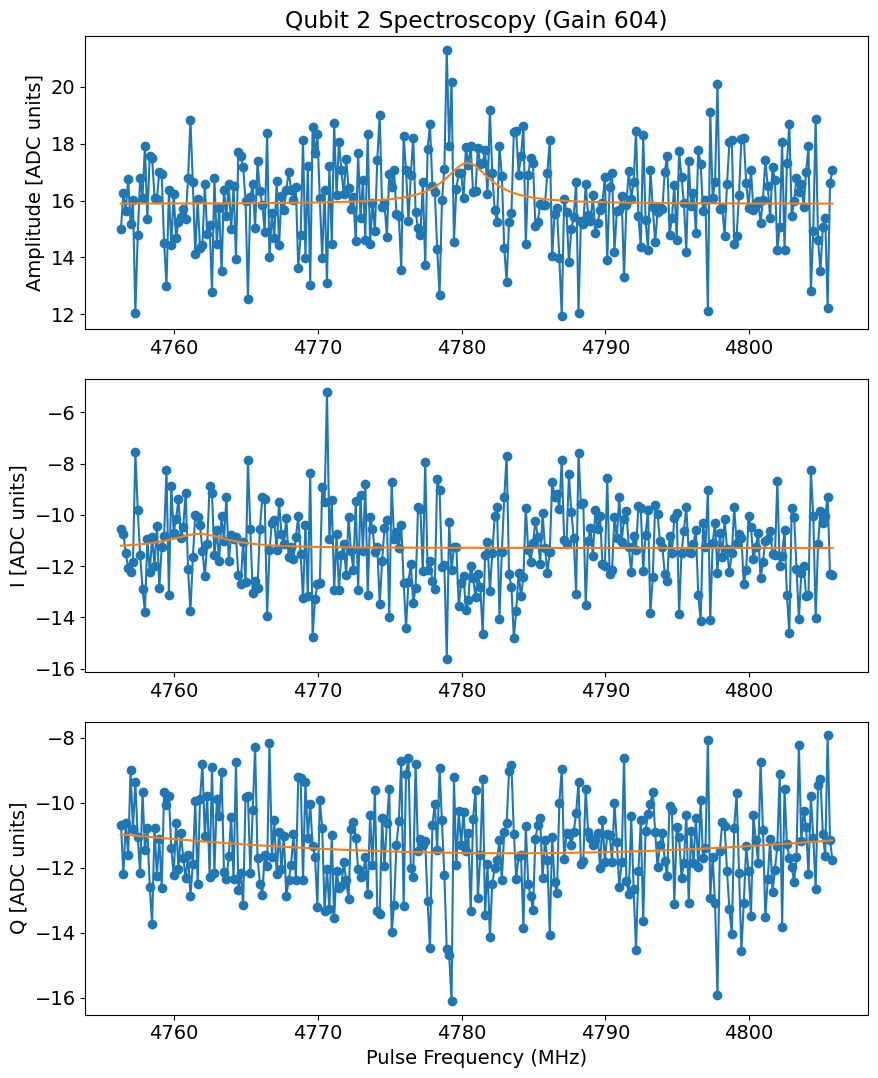

*Set qubit 2 f_ge to 4780.411006069921*
{'Res freq': 7697.501366666667, 'Res kappa': 0.9867568400000002, 'Qubit freq': 4780.411006069921}


In [68]:
# # TESTING
# # qspec = meas.PulseProbeSpectroscopyExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00001_qubit_spectroscopy_qubit0.h5')
# qspec.data = temp_data

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    try: 
        qspec.analyze(fit=True, signs=[1, sign, sign])
        fit_err_i = qspec.data['fit_err_avgi'][2][2]
        fit_err_q = qspec.data['fit_err_avgq'][2][2]
        if fit_err_i < best_fit_err_i:
            best_signs[1] = sign
            best_fit_err_i = fit_err_i
        if fit_err_q < best_fit_err_q:
            best_signs[2] = sign
            best_fit_err_q = fit_err_q
    except: continue
if best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qspec.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qspec.analyze(fit=True, signs=best_signs)
qspec.display(fit=True, signs=best_signs)

qspec_fit, qspec_fit_err = meas.fitting.get_best_fit(qspec.data)
yaml_cfg.device.qubit.f_ge[qubit_i] = qspec_fit[2]
print(f'*Set qubit {qubit_i} f_ge to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')

results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(results_Qi)

In [89]:
if save_data: saved_files.append(qspec.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230927\00000_qubit_spectroscopy_qubit3.h5


## Pulse Probe (qubit) spectroscopy round 2

In [71]:
qspec2 = meas.PulseProbeSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qspec2.cfg = AttrDict(deepcopy(yaml_cfg))

span = 10
npts = 150

qspec2.cfg.expt = dict(
    start=qspec2.cfg.device.qubit.f_ge[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=100, # Number of averages per point
    rounds=20, # Number of start to finish sweeps to average over
    length=1, # Qubit probe constant pulse length [us]
    gain=int(yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]/15), # Qubit pulse gain
    pulse_type='gauss',
    qubit=qubit_i,
)
qspec2.cfg.device.readout.relax_delay = 10 # Wait time between experiments [us]
qspec2.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/20 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4780.960750853483, HWHM 0.9269043488552832
Found peak in I at [MHz] 4780.9497000737465, HWHM 0.9716509757275478
Found peak in Q at [MHz] 4781.059487616919, HWHM 0.5778050755666603


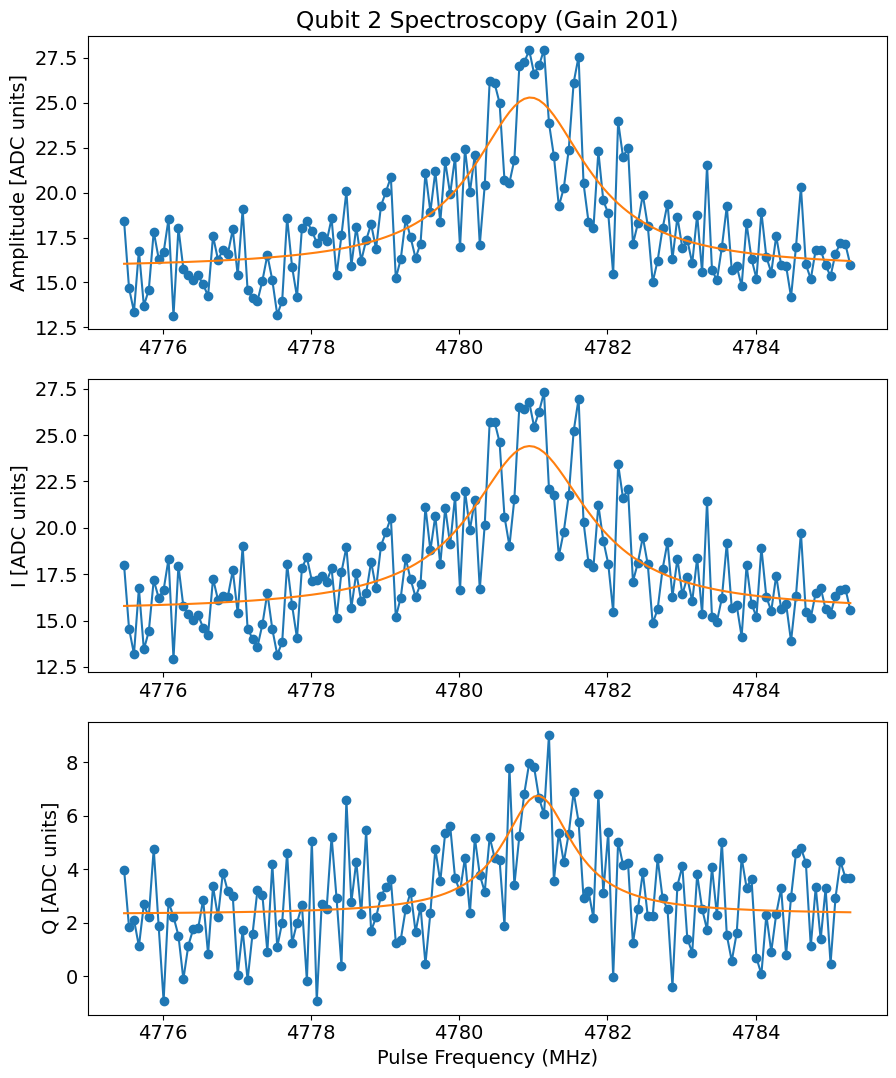

*Set qubit 2 f_ge to 4780.960750853483*
{'Res freq': 7697.501366666667, 'Res kappa': 0.9867568400000002, 'Qubit freq': 4780.960750853483}


In [72]:
# # TESTING
# # qspec2 = meas.PulseProbeSpectroscopyExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00001_qubit_spectroscopy_qubit0.h5')
# qspec2.data = temp_data

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    try: 
        qspec2.analyze(fit=True, signs=[1, sign, sign])
        fit_err_amps = qspec2.data['fit_err_amps'][2][2]
        fit_err_i = qspec2.data['fit_err_avgi'][2][2]
        fit_err_q = qspec2.data['fit_err_avgq'][2][2]
        if fit_err_i < best_fit_err_i:
            best_signs[1] = sign
            best_fit_err_i = fit_err_i
        if fit_err_q < best_fit_err_q:
            best_signs[2] = sign
            best_fit_err_q = fit_err_q
    except: continue
if fit_err_amps == np.inf and best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qspec2.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qspec2.analyze(fit=True, signs=best_signs)
qspec2.display(fit=True, signs=best_signs)

qspec2_fit, qspec2_fit_err = meas.fitting.get_best_fit(qspec2.data)
yaml_cfg.device.qubit.f_ge[qubit_i] = qspec2_fit[2]
qubit_hwhm = qspec2_fit[3]
print(f'*Set qubit {qubit_i} f_ge to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')

results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(results_Qi)

In [92]:
if save_data: saved_files.append(qspec2.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230927\00001_qubit_spectroscopy_qubit3.h5


## Length Rabi

In [93]:
lengthrabi = meas.LengthRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabi_qubit{qubit_i}",
    config_file=config_path,
)
lengthrabi.cfg = AttrDict(deepcopy(yaml_cfg))

lengthrabi.cfg.expt = dict(
    start=0, # pulse length (sigma) [us]
    step=soc.cycles2us(1), # [us]
    # step=0.001,
    expts=121,
    reps=2000,
    gain=yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i], # qubit gain [DAC units],
    # gain=32000, # qubit gain [DAC units],
    pulse_type='gauss',
    checkZZ=False,
    checkEF=False, 
    qubits=[qubit_i],
)
# lengthrabi.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]

import Pyro4.util
try:
    lengthrabi.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/121 [00:00<?, ?it/s]

Decay from avgi [us] 0.3153294901663501
Pi length from avgi data [us]: 0.0154181718528753
	Pi/2 length from avgi data [us]: 0.00770908592643765

Decay from avgq [us] 0.19801211239592198
Pi length from avgq data [us]: 0.014337528046500547
Pi/2 length from avgq data [us]: 0.0071687640232502734


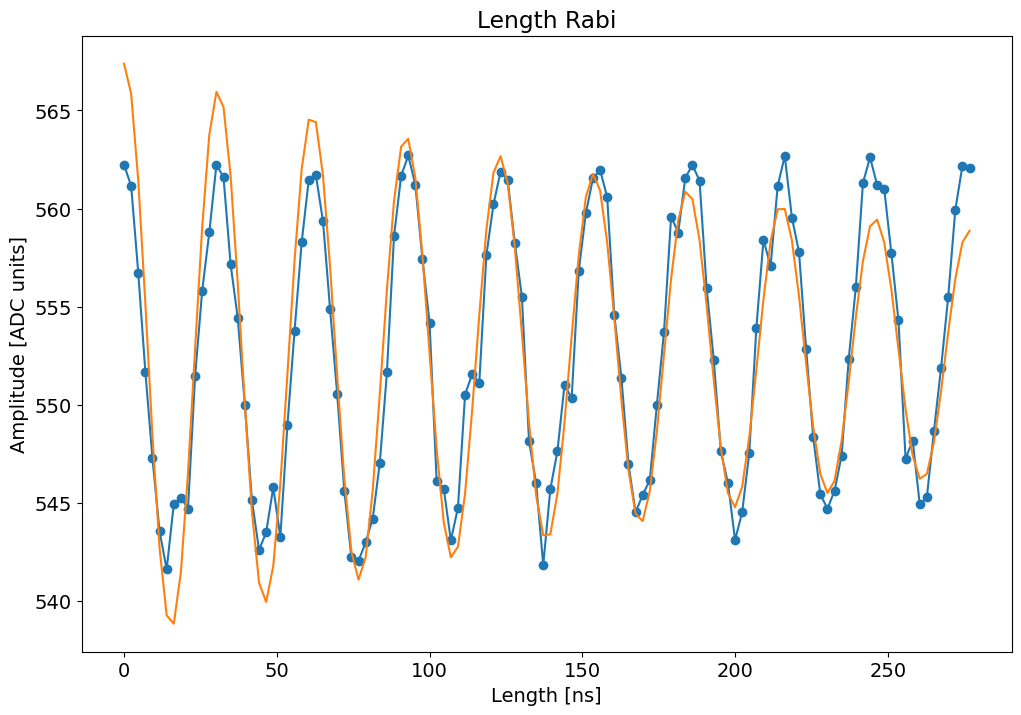

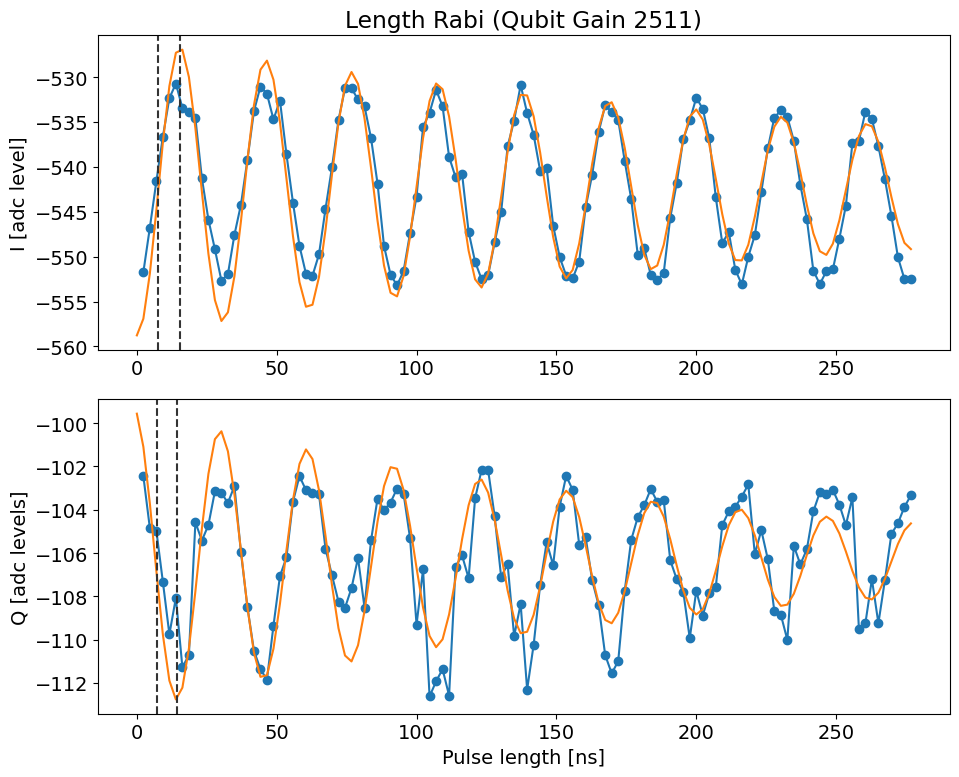

Will use sigma 0.015 for amplitude rabi


In [94]:
# # TESTING
# # lengthrabi = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# lengthrabi.data = temp_data

lengthrabi.analyze(fit=True)

lengthrabi_fit, lengthrabi_fit_err = meas.fitting.get_best_fit(lengthrabi.data) #, fitfunc=fitter.decaysin)

lengthrabi.display(fit=True)
p = lengthrabi_fit
if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_len = (1/2 - p[2]/180)/2/p[1]
else: pi_len = (3/2 - p[2]/180)/2/p[1]
pi_len = np.max((0.9*pi_len, 0.015)) # since we run the length rabi at a < max gain

lengthrabi_decay = p[3]

print(f'Will use sigma {pi_len} for amplitude rabi')

In [95]:
if save_data: saved_files.append(lengthrabi.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230927\00000_length_rabi_qubit3.h5


## Amplitude Rabi

In [73]:
# pi_len = 0.100
pi_len = yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i]

In [74]:
amprabi = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit{qubit_i}",
    config_file=config_path,
)
amprabi.cfg = AttrDict(deepcopy(yaml_cfg))

span = min((32000, int(1.5*yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i])))
npts = 151
    
amprabi.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=100,
    # reps=5,
    rounds=20,
    sigma_test=pi_len, # gaussian sigma for pulse length - overrides config [us]
    pulse_type='gauss',
    checkZZ=False,
    checkEF=False, 
    qubits=[qubit_i],
)
amprabi.go(analyze=False, display=False, progress=True, save=False)

gauss


  0%|          | 0/20 [00:00<?, ?it/s]

Pi gain from amps data [dac units]: 2806
	Pi/2 gain from amps data [dac units]: 1403
Pi gain from avgi data [dac units]: 2808
	Pi/2 gain from avgi data [dac units]: 1404
Pi gain from avgq data [dac units]: 2791
	Pi/2 gain from avgq data [dac units]: 1395


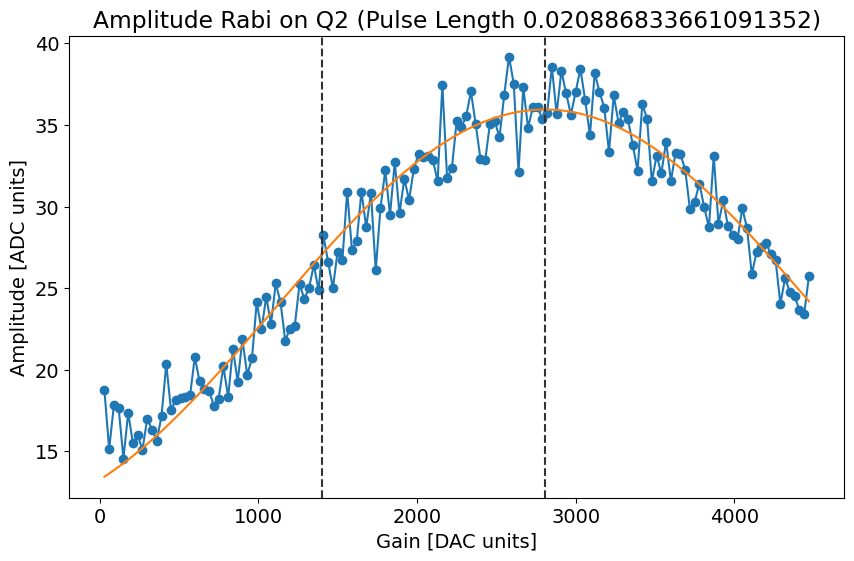

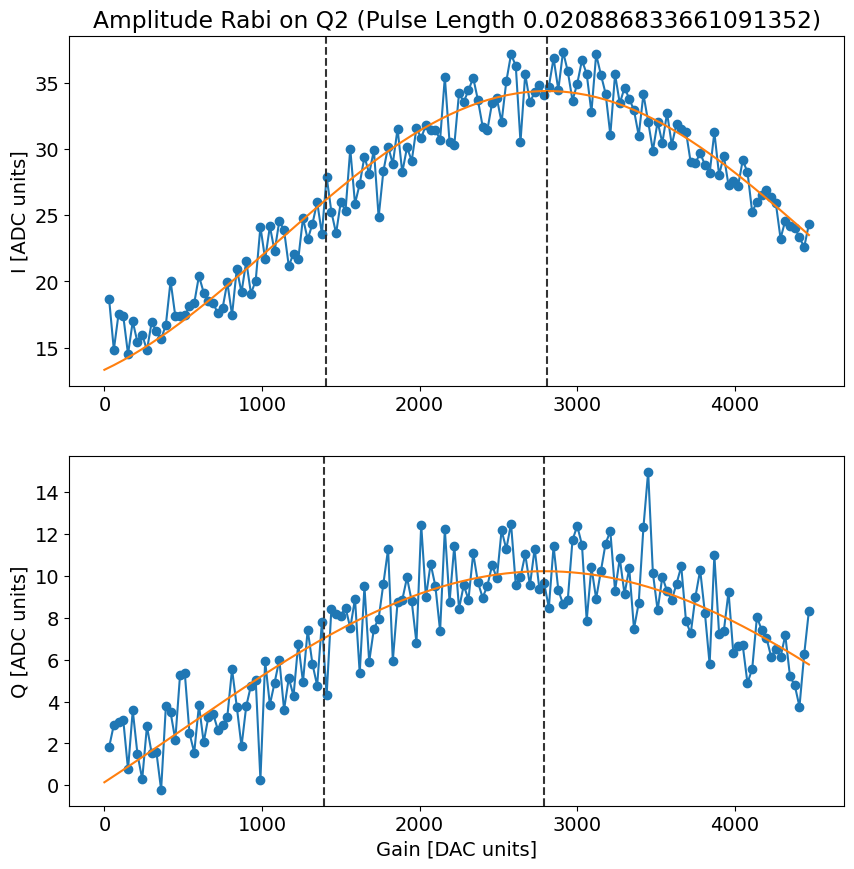

*Set pi pulse sigma for qubit 2 to 0.020886833661091352*
*Set pi pulse gain for qubit 2 to 2806*
{'Res freq': 7697.501366666667, 'Res kappa': 0.9867568400000002, 'Qubit freq': 4780.960750853483, 'Pi pulse len': 0.020886833661091352, 'Pi pulse gain': 2806}


In [75]:
# # TESTING
# # amprabi = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# amprabi.data = temp_data

amprabi.analyze(fit=True)

amprabi_fit, amprabi_fit_err = meas.fitting.get_best_fit(amprabi.data)

p = amprabi_fit
if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
else: pi_gain = (3/2 - p[2]/180)/2/p[1]

if pi_gain > 32000:
    amprabi.display(fit=False)
    print(f'WARNING: Fit pi pulse gain is long ({pi_gain}), please double check!')
    pi_gain = 30000
else: amprabi.display(fit=True)
yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i] = amprabi.cfg.expt.sigma_test

print(f'*Set pi pulse sigma for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i]}*')
yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i] = int(pi_gain)
print(f'*Set pi pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]}*')
results_Qi.update({'Pi pulse len':yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i]})
results_Qi.update({'Pi pulse gain':yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]})
print(results_Qi)

In [99]:
if save_data: saved_files.append(amprabi.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230927\00000_amp_rabi_qubit3.h5


## $T_1$

In [43]:
# if lengthrabi_decay < 10: short_T1 = True
# else: short_T1 = False
short_T1 = False

In [47]:
t1 = meas.T1Experiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"t1_qubit{qubit_i}",
    config_file=config_path,
)
t1.cfg = AttrDict(deepcopy(yaml_cfg))

span = 50 if short_T1 else 400
npts = 151

t1.cfg.expt = dict(
    start=0, # wait time [us]
    step=span/npts,
    expts=npts,
    reps=100,
    # reps=5,
    rounds=20,
    qubit=qubit_i,
)
t1.cfg.device.readout.relax_delay = span # Wait time between experiments [us]
t1.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/20 [00:00<?, ?it/s]

Fit T1 avgi [us]: 62.05841430011498
Fit T1 avgq [us]: 72.81565994413273


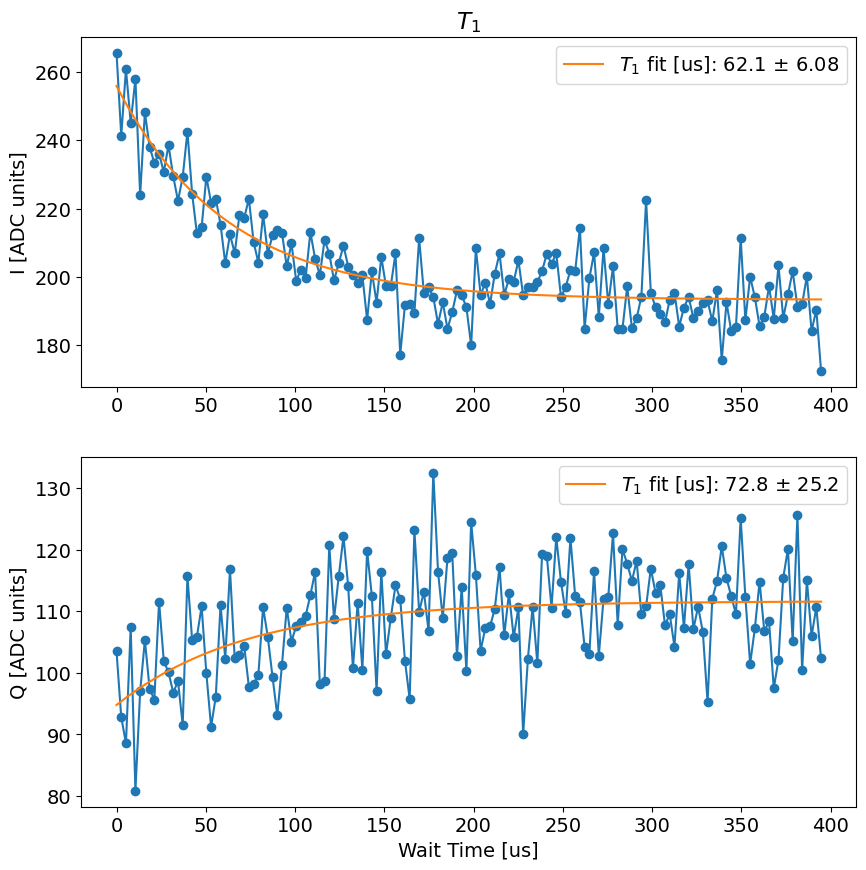

*Set qubit 1 T1 to 57.0*
*Set readout 1 relax delay to 229.0*
{'Qubit freq': 3453.880553592635, 'Pi pulse len': 0.1, 'Pi pulse gain': 30000, 'T1': 57.18285129876475, 'T1 err': 7.07905374775865}


In [48]:
# # TESTING
# # t1 = meas.T1Experiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_t1_qubit1.h5')
# t1.data = temp_data

t1.analyze(fit=True)

t1_fit, t1_fit_err = meas.fitting.get_best_fit(t1.data) #, fitter.expfunc)

t1.display(fit=True)
yaml_cfg.device.qubit.T1[qubit_i] = np.round(t1_fit[3])
yaml_cfg.device.readout.relax_delay[qubit_i] = np.round(4*t1_fit[3])
print(f'*Set qubit {qubit_i} T1 to {yaml_cfg.device.qubit.T1[qubit_i]}*')
print(f'*Set readout {qubit_i} relax delay to {yaml_cfg.device.readout.relax_delay[qubit_i]}*')
results_Qi.update({'T1':t1_fit[3], 'T1 err':np.sqrt(t1_fit_err[3][3])})
print(results_Qi)

In [49]:
if save_data: saved_files.append(t1.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230927\00000_t1_qubit1.h5


## $T_2$ Ramsey round 1

In [76]:
# yaml_cfg.device.qubit.f_ge[qubit_i] = 145.572034953271
# qubit_hwhm = 2
short_T1 = False
# short_T1 = yaml_cfg.device.qubit.T1[qubit_i] < 20
print('Short T1', short_T1)

Short T1 False


In [77]:
ramsey_freq = max((min((np.abs(np.ceil(qubit_hwhm)), 3)), 2))
# ramsey_freq = 1
print(f'Ramsey freq [MHz]: {ramsey_freq}')

t2r = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ramsey_qubit{qubit_i}",
    config_file=config_path,
)
t2r.cfg = AttrDict(deepcopy(yaml_cfg))

# make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
t2r.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(1) if short_T1 else soc.cycles2us(8), # [us] 
    # step=soc.cycles2us(2) if short_T1 else soc.cycles2us(10), # [us] 
    expts=200,
    ramsey_freq=ramsey_freq, # [MHz]
    reps=150,
    # reps=5,
    rounds=20,
    qubits=[qubit_i],
    checkZZ=False,
    checkEF=False,
)

import Pyro4.util
try:
    t2r.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

Ramsey freq [MHz]: 2.0


  0%|          | 0/20 [00:00<?, ?it/s]

Current pi pulse frequency: 4780.960750853483
Fit frequency from amps [MHz]: 1.9375343148066864 +/- 0.0035994647256036858
Suggested new pi pulse frequencies from fit amps [MHz]:
 	4781.023216538676
 	4777.023216538676
T2 Ramsey from fit amps [us]: 3.2900673214165326
Current pi pulse frequency: 4780.960750853483
Fit frequency from I [MHz]: 1.9387016274641633 +/- 0.003785676929933098
Suggested new pi pulse frequency from fit I [MHz]:
 	4781.022049226019
 	4777.022049226019
T2 Ramsey from fit I [us]: 3.2310127562279525
Fit frequency from Q [MHz]: 1.9225570977340292 +/- 0.0077806457682913464
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4781.038193755749
 	4777.038193755749
T2 Ramsey from fit Q [us]: 2.1132431450477376


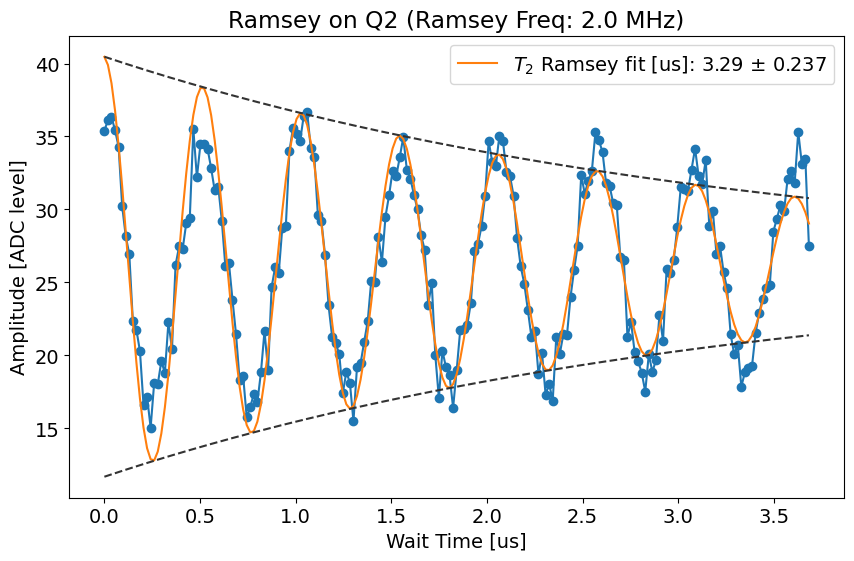

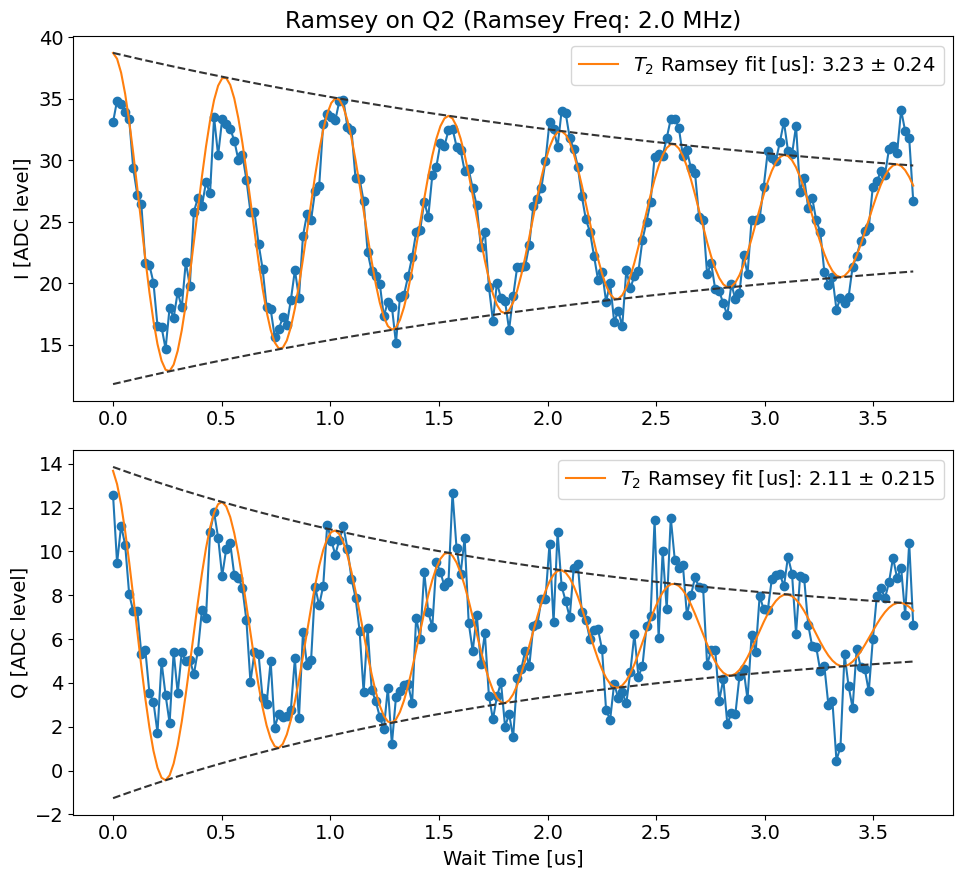

*Set qubit 2 freq to 4781.023216538676*
Alt qubit freq is 4777.023216538676


In [78]:
# # TESTING
# # t2r = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
# t2r.data = temp_data

t2r.analyze(fit=True)

t2r_fit, t2r_fit_err, t2r_adjust = meas.fitting.get_best_fit(t2r.data, get_best_data_params=['f_adjust_ramsey'])

old_qubit_freq = t2r.cfg.device.qubit.f_ge[qubit_i]
t2r.display(fit=True)
yaml_cfg.device.qubit.f_ge[qubit_i] = old_qubit_freq + t2r_adjust[0]
alt_qubit_freq = old_qubit_freq + t2r_adjust[1]
print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')
print(f'Alt qubit freq is {alt_qubit_freq}')

In [102]:
if save_data: saved_files.append(t2r.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230927\00000_ramsey_qubit3.h5


## $T_2$ Ramsey round 2

Check that frequency adjustment helps.

In [79]:
t2r_2 = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ramsey_qubit{qubit_i}",
    config_file=config_path,
)
t2r_2.cfg = AttrDict(deepcopy(yaml_cfg))

# make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
t2r_2.cfg.expt = dict(
    start=0, # wait time tau [us]
    # step=soc.cycles2us(2) if t2r_fit[3] < 3 else soc.cycles2us(60), # [us]
    step=soc.cycles2us(60), # [us]
    expts=151,
    ramsey_freq=ramsey_freq/10, # [MHz]
    reps=100,
    # reps=10,
    rounds=30,
    checkZZ=False,
    checkEF=False,
    qubits=[qubit_i],
)
t2r_2.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Current pi pulse frequency: 4781.023216538676
Fit frequency from amps [MHz]: 0.18660634837346599 +/- 0.0015881525196856055
Suggested new pi pulse frequencies from fit amps [MHz]:
 	4781.036610190303
 	4780.636610190302
T2 Ramsey from fit amps [us]: 8.076684919317689
Current pi pulse frequency: 4781.023216538676
Fit frequency from I [MHz]: 0.18656428495244082 +/- 0.0017017919261326376
Suggested new pi pulse frequency from fit I [MHz]:
 	4781.036652253723
 	4780.636652253724
T2 Ramsey from fit I [us]: 7.943007942455919
Fit frequency from Q [MHz]: 0.18646145802423433 +/- 0.0024719144401772336
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4781.036755080651
 	4780.636755080652
T2 Ramsey from fit Q [us]: 8.992710644419303


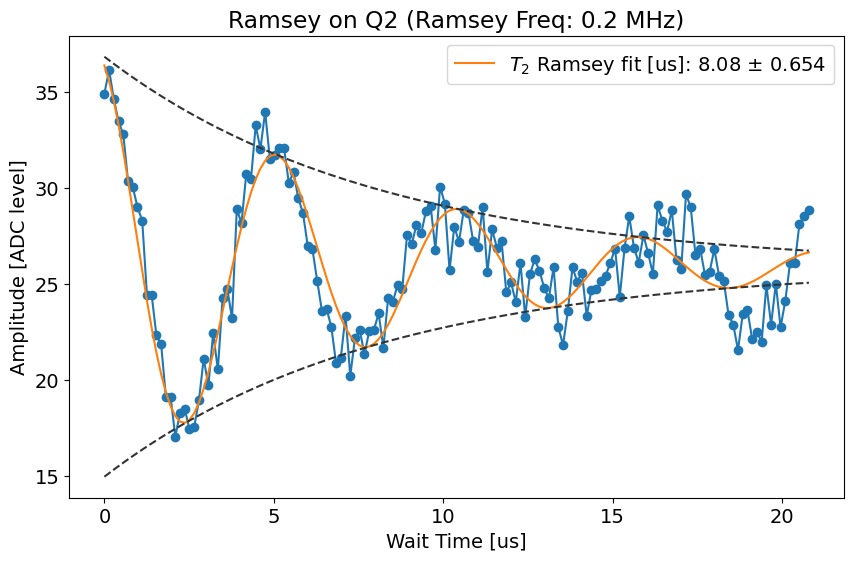

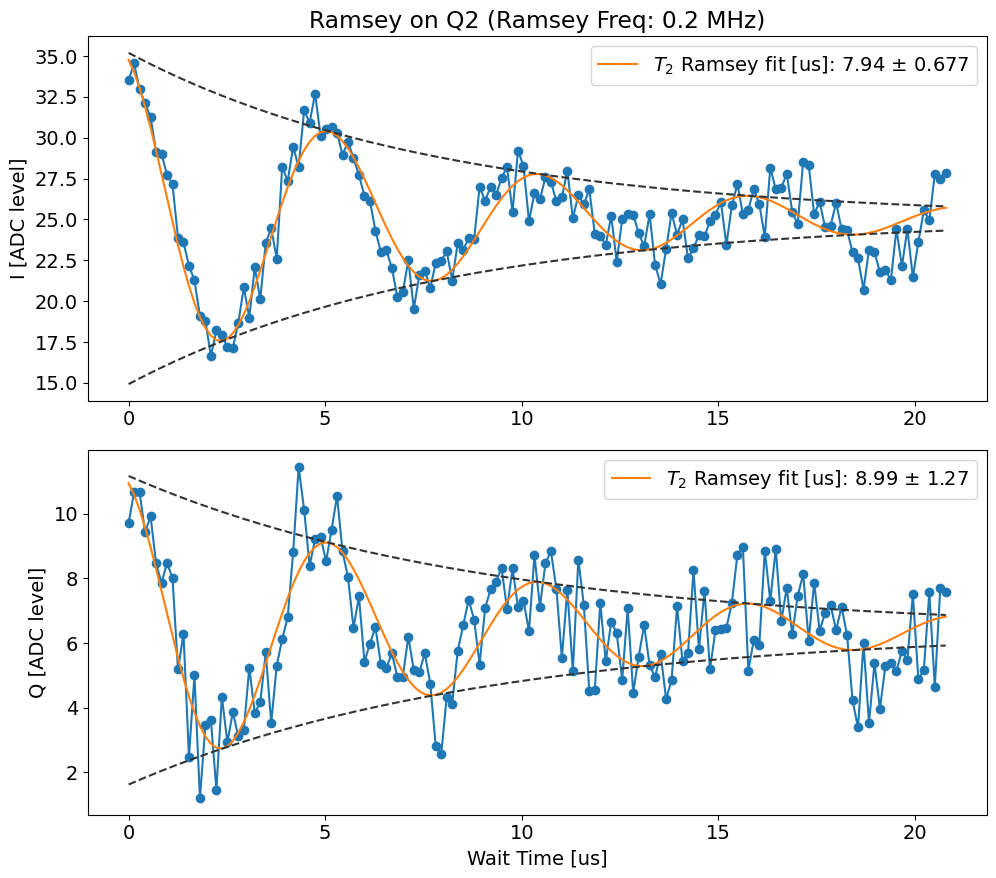

*Set qubit 2 freq to 4781.036610190303*
{'Res freq': 7697.501366666667, 'Res kappa': 0.9867568400000002, 'Qubit freq': 4781.036610190303, 'Pi pulse len': 0.020886833661091352, 'Pi pulse gain': 2806, 'T2R': 8.076684919317689, 'T2R err': 0.6537235616742789}
Redo T2R: False


In [80]:
# # TESTING
# # t2r_2 = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
# t2r_2.data = temp_data

redo_t2r = True

t2r_2.analyze(fit=True)

t2r_2_fit, t2r_2_fit_err, t2r_2_adjust = meas.fitting.get_best_fit(t2r_2.data, get_best_data_params=['f_adjust_ramsey'])

t2r_2.display(fit=True)
final_qubit_freq = t2r_2.cfg.device.qubit.f_ge[qubit_i] + t2r_2_adjust[0]
if abs(t2r_2_adjust[0]) <= ramsey_freq/10:
# if abs(t2r_2_adjust[0]) <= abs(t2r_adjust[0]):
    redo_t2r = False
    yaml_cfg.device.qubit.f_ge[qubit_i] = final_qubit_freq
    print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')
    results_Qi.update({'T2R':t2r_2_fit[3], 'T2R err':np.sqrt(t2r_2_fit_err[3][3])})
    results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
    print(results_Qi)
else: # redo_t2r = True
    yaml_cfg.device.qubit.f_ge[qubit_i] = alt_qubit_freq 
    print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')
print(f'Redo T2R: {redo_t2r}')

In [105]:
if save_data: saved_files.append(t2r_2.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230927\00001_ramsey_qubit3.h5


## $T_2$ Ramsey round 3

Run again in case adjust frequency in the wrong direction previously.

In [398]:
if redo_t2r:
    t2r_3 = meas.RamseyExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"ramsey_qubit{qubit_i}",
        config_file=config_path,
    )
    t2r_3.cfg = AttrDict(deepcopy(yaml_cfg))

    # make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    t2r_3.cfg.expt = dict(
        start=0, # wait time tau [us]
        step=soc.cycles2us(2) if short_T1 else soc.cycles2us(10), # [us]
        expts=151,
        ramsey_freq=ramsey_freq/2, # [MHz]
        reps=100,
        # reps=10,
        rounds=30,
        checkZZ=False,
        checkEF=False,
        qubits=[qubit_i],
    )
    t2r_3.go(analyze=False, display=False, progress=True, save=False)

In [399]:
if redo_t2r:
    # # TESTING
    # # t2r_3 = meas.RamseyExperiment(config_file=config_path)
    # temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
    # t2r_3.data = temp_data

    t2r_3.analyze(fit=True)

    t2r_3_fit, t2r_3_fit_err, t2r_3_adjust = meas.fitting.get_best_fit(t2r_3.data, compare_param_i=3, get_best_data_params=['f_ge_adjust_ramsey'])

    if not isinstance(t2r_3_fit, (list, np.ndarray)):
        t2r_3.display(fit=True)
        final_qubit_freq = t2r_3.cfg.device.qubit.f_ge + t2r_3_adjust[0]
        if abs(t2r_3_adjust[0]) <= abs(t2r_adjust[0]):
            yaml_cfg.device.qubit.f_ge[qubit_i] = final_qubit_freq
            print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')
            i_best = np.argmin([t2r_fit_err[3][3], t2r_3_fit_err[3][3]])
            results_Qi.update({'T2':[t2r_fit[3], t2r_3_fit[3]][i_best], 'T2 err':np.sqrt([t2r_fit_err[3][3], t2r_3_fit_err[3][3]][i_best])})
            results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
            print(all_results)
        else:
            assert False, 'Something is wrong, please manually fix!'
    else:
        t2r_3.display(fit=False)
        assert False, 'Fit failed, please manually fix!'

In [400]:
if redo_t2r:
    if save_data: saved_files.append(t2r_3.save_data())

## $T_2$ Echo

In [59]:
t2e = meas.RamseyEchoExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"echo_qubit{qubit_i}",
    config_file=config_path,
)
t2e.cfg = AttrDict(deepcopy(yaml_cfg))

t2e.cfg.expt = dict(
    start=0, # total wait time b/w the two pi/2 pulses [us]
    step=soc.cycles2us(80), # make sure nyquist freq = 0.5*(1/step) > ramsey (signal) freq!
    expts=151,
    ramsey_freq=max((ramsey_freq/10, 0.100)), # frequency by which to advance phase [MHz]
    num_pi=1, # number of pi pulses
    cpmg=True, # set either cp or cpmg to True
    cp=False, # set either cp or cpmg to True
    reps=100,
    # reps=10,
    rounds=30,
    qubit=qubit_i,
)
t2e.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 1.2902399999999998, which is out of bounds 0.0036080536912751677 to 0.5412080536912751. Instead init to 0.27240805369127513
Current qubit frequency: 3454.211606121115
Fit frequency from I [MHz]: 0.1977204056219007 +/- 0.0014847418257556513
T2 Echo from fit I [us]: 11.380580335794997
Fit frequency from Q [MHz]: 0.29040166314813304 +/- 0.004332126396466633
T2 Echo from fit Q [us]: 8.314732142857144


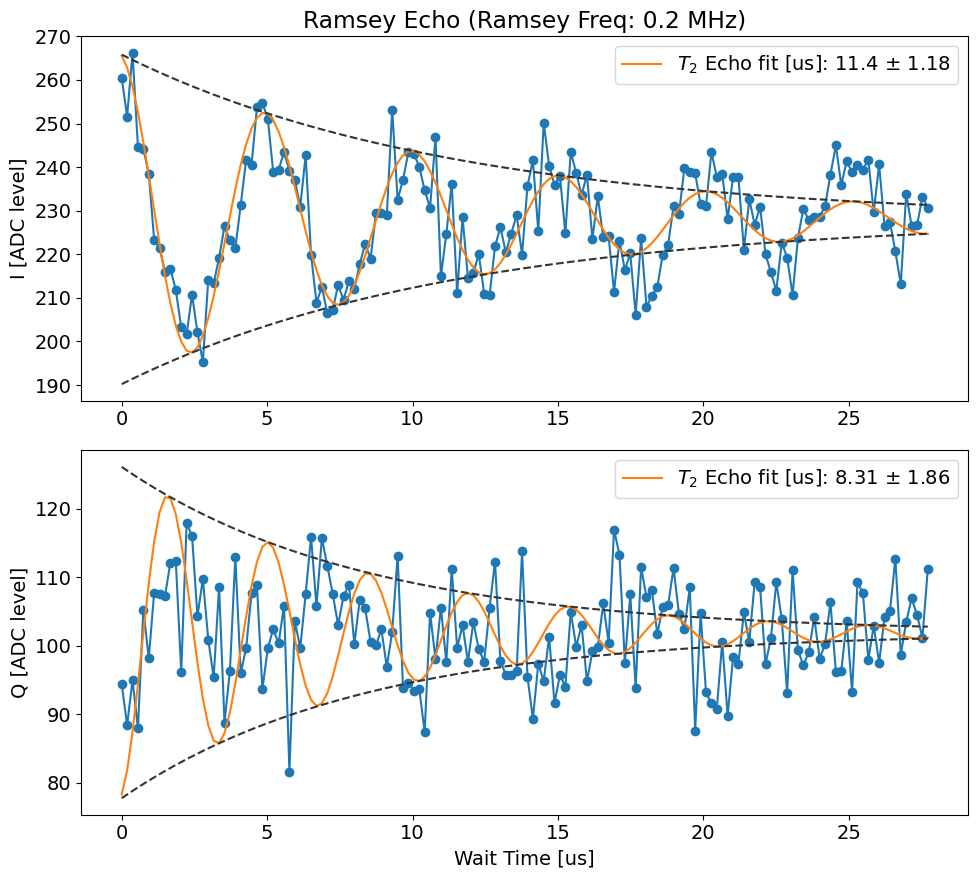

{'Qubit freq': 3454.211606121115, 'Pi pulse len': 0.1, 'Pi pulse gain': 30000, 'T1': 57.18285129876475, 'T1 err': 7.07905374775865, 'T2R': 6.236049107142858, 'T2R err': 0.7232190821449542, 'T2E': 11.380580335794997, 'T2E err': 1.18451198169079}


In [60]:
# # TESTING
# # t2e = meas.RamseyEchoExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_echo_qubit1.h5')
# t2e.data = temp_data

t2e.analyze(fit=True)

t2e_fit, t2e_fit_err = meas.fitting.get_best_fit(t2e.data)

if not isinstance(t2e_fit, (list, np.ndarray)):
    t2e.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

t2e.display(fit=True)
results_Qi.update({'T2E':t2e_fit[3], 'T2E err':np.sqrt(t2e_fit_err[3][3])})
print(results_Qi)
# print('Results updated.')

In [61]:
if save_data: saved_files.append(t2e.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230927\00000_echo_qubit1.h5


# Resonator chi shift (g/e)

In [14]:
rspec_chi = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_chi_qubit{qubit_i}",
    config_file=config_path,
)
rspec_chi.cfg = AttrDict(deepcopy(yaml_cfg))

span = 5 # MHz
npts = 151
rspec_chi.cfg.expt = dict(
    start=rspec_chi.cfg.device.readout.frequency[qubit_i]-span/2, # MHz
    # start=rspec_chi.cfg.device.readout.frequency[qubit_i]-rspec_chi.cfg.device.readout.lo_sideband[qubit_i]*span, # MHz
    step=span/npts,
    expts=npts,
    reps=3000,
    pulse_e=True, # add ge pi pulse prior to measurement
    pulse_f=False, # add ef pi pulse prior to measurement
    qubit=qubit_i,
)
# rspec_chi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]
rspec_chi.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/151 [00:00<?, ?it/s]

[-70.08562496489304, 5000, 1000, 0, 42.65341198941371, 36.379241553802686, -1.1946207095916723]

Freq with minimum transmission: -68.03264483244271
Freq with maximum transmission: -71.17834019668112
From fit:
	f0: [6804.91437504 5045.08562496 6804.91437504 6804.91437504]
	Qi: 5000
	Qe: 1000
	Q0: 833.3333333333333
	kappa [MHz]: [8.16589725 6.05410275 8.16589725 8.16589725]
	phi [radians]: 0


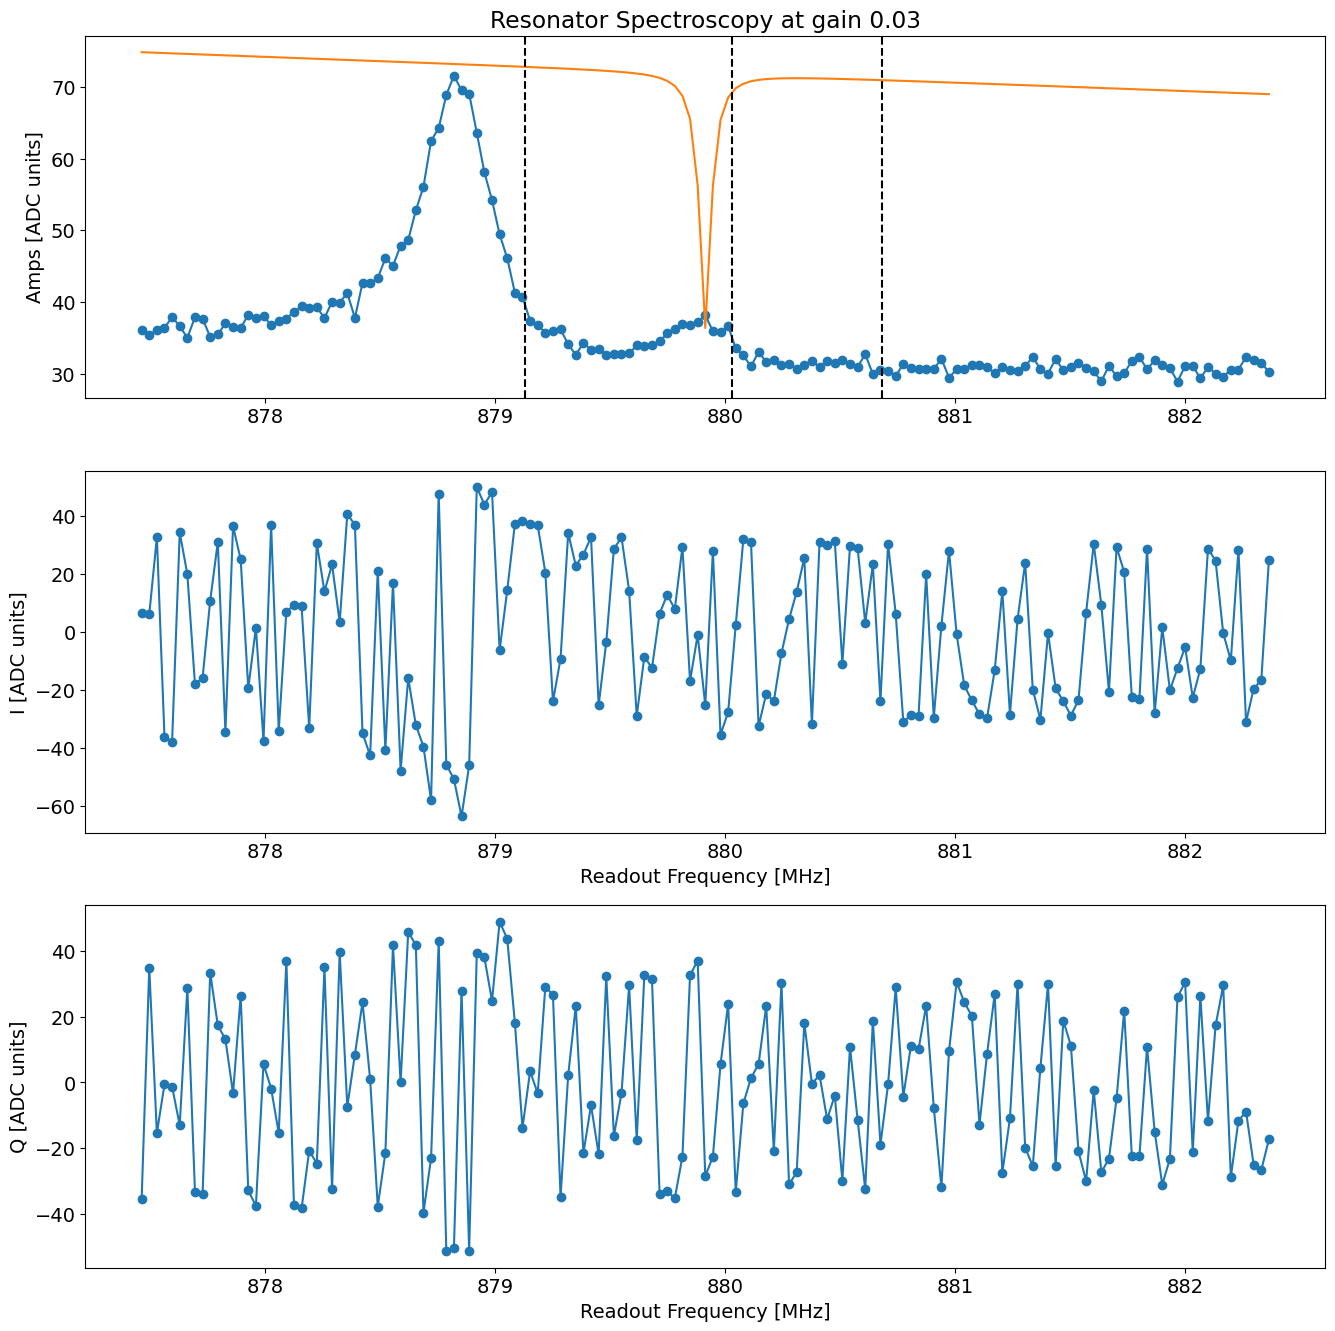

[{'Res chi shift (e - g)': -1.1092715231788048}, {}, {}, {}]


In [16]:
# # TESTING
# # rspec_chi = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# temp_data, attrs = prev_data(expt_path, '00001_resonator_spectroscopy_qubit2.h5')
# rspec_chi.data = temp_data

rspec_chi.analyze(fit=True)
rspec_chi_fit = rspec_chi.data['fit']
if not isinstance(rspec_chi_fit, (list, np.ndarray)):
    rspec_chi.display(fit=False)
    assert False, 'Fit failed, please manually fix!'
rspec_chi.display(fit=True)
# res_freq_e = rspec_chi_fit[0]
# res_freq_e = rspec_chi.data['xpts'][np.argmin(rspec_chi.data['amps'])]
res_freq_e = rspec_chi.data['xpts'][np.argmax(rspec_chi.data['amps'])]
# res_freq_e = -83
results_Qi.update({'Res chi shift (e - g)': yaml_cfg.device.readout.lo_sideband[qubit_i]*(res_freq_e - yaml_cfg.device.readout.frequency[qubit_i])})
# res_freq_e = 6953.5
# results_Qi.update({'Res chi shift (e - g)': res_freq_e - (5925 + yaml_cfg.device.readout.lo_sideband[qubit_i]*(yaml_cfg.hw.soc.dacs.readout.mixer_freq + yaml_cfg.device.readout.frequency[qubit_i]))})
print(all_results)

In [344]:
if save_data: saved_files.append(rspec_chi.save_data())

# Qubit ef spectroscopy

## Pulse Probe ef spectroscopy

In [62]:
qEFspec = meas.PulseProbeEFSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_EF_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qEFspec.cfg = AttrDict(deepcopy(yaml_cfg))

span = 50
npts = 150

qEFspec.cfg.expt = dict(
    start=qEFspec.cfg.device.qubit.f_ef[qubit_i]-0.5*span, # resonator frequency to be mixed up [MHz]
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number of experiments stepping from start
    reps=100, # Number of averages per point
    rounds=30, # Number of start to finish sweeps to average over
    length=1, # ef probe constant pulse length [us]
    gain=int(yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]/50), # ef pulse gain
    # gain=5000,
    pulse_type='gauss',
    qubit=qubit_i,
)
qEFspec.cfg.device.readout.relax_delay = qEFspec.cfg.device.qubit.T1[qubit_i] # Wait time between experiments [us]
qEFspec.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Found peak in amps at [MHz] 3360.1696039400604, HWHM 2.5617537234601477
Found peak in I at [MHz] 3358.700364022914, HWHM 2.893341237990473
Found peak in Q at [MHz] 3361.5445066481175, HWHM -0.7647795695518026


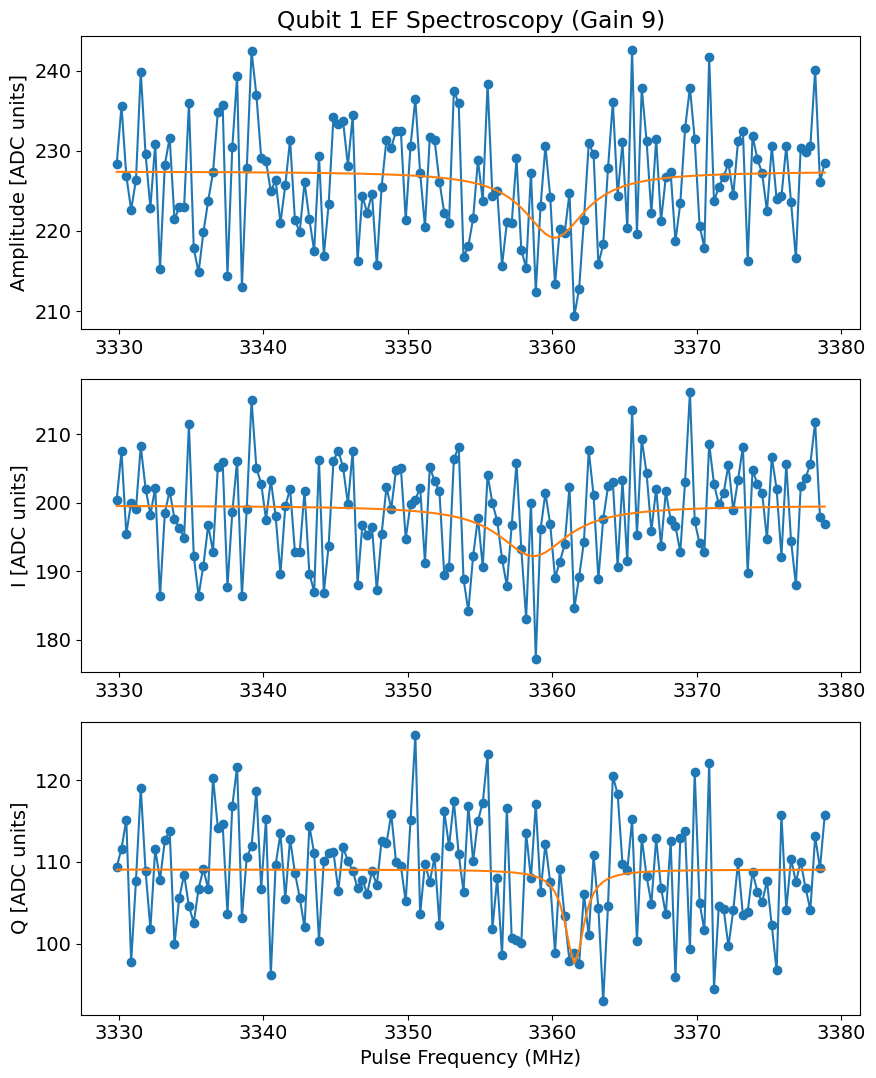

*Set qubit 1 f_ef to 3361.5445066481175*
[{}, {'Qubit freq': 3454.211606121115, 'Pi pulse len': 0.1, 'Pi pulse gain': 30000, 'T1': 57.18285129876475, 'T1 err': 7.07905374775865, 'T2R': 6.236049107142858, 'T2R err': 0.7232190821449542, 'T2E': 11.380580335794997, 'T2E err': 1.18451198169079, 'Qubit EF freq': 3361.5445066481175}, {}, {}]


In [63]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = qEFspec.analyze(data=temp_data, fit=True)

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    try: 
        qEFspec.analyze(fit=True, signs=[1, sign, sign])
        fit_err_i = qEFspec.data['fit_err_avgi'][2][2]
        fit_err_q = qEFspec.data['fit_err_avgq'][2][2]
        if fit_err_i < best_fit_err_i:
            best_signs[1] = sign
            best_fit_err_i = fit_err_i
        if fit_err_q < best_fit_err_q:
            best_signs[2] = sign
            best_fit_err_q = fit_err_q
    except: continue
if best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qEFspec.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qEFspec.analyze(fit=True, signs=best_signs)
qEFspec.display(fit=True, signs=best_signs)

better_fit = (qEFspec.data['fit_avgi'], qEFspec.data['fit_avgq'])[np.argmin((qEFspec.data['fit_err_avgi'][2][2], qEFspec.data['fit_err_avgq'][2][2]))]
yaml_cfg.device.qubit.f_ef[qubit_i] = better_fit[2]
print(f'*Set qubit {qubit_i} f_ef to {yaml_cfg.device.qubit.f_ef[qubit_i]}*')

results_Qi.update({'Qubit EF freq':yaml_cfg.device.qubit.f_ef[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(all_results)

In [124]:
if save_data: saved_files.append(qEFspec.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230927\00000_qubit_EF_spectroscopy_qubit0.h5


## Pulse Probe EF spectroscopy round 2

In [126]:
qEFspec2 = meas.PulseProbeEFSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_EF_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qEFspec2.cfg = AttrDict(deepcopy(yaml_cfg))

span = 20
npts = 150

qEFspec2.cfg.expt = dict(
    start=qEFspec2.cfg.device.qubit.f_ef[qubit_i]-0.5*span, # resonator frequency to be mixed up [MHz]
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number of experiments stepping from start
    reps=100, # Number of averages per point
    rounds=30, # Number of start to finish sweeps to average over
    length=1, # ef probe constant pulse length [us]
    gain=int(yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]/100), # ef pulse gain
    pulse_type='gauss',
    qubit=qubit_i,
)
qEFspec2.cfg.device.readout.relax_delay = qEFspec2.cfg.device.qubit.T1[qubit_i] # Wait time between experiments [us]
qEFspec2.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Found peak in amps at [MHz] 3900.3584514047434, HWHM -0.42681487401867796
Found peak in I at [MHz] 3900.359843042615, HWHM -0.4321158207479403
Found peak in Q at [MHz] 3900.35770701028, HWHM 0.42258002024579394


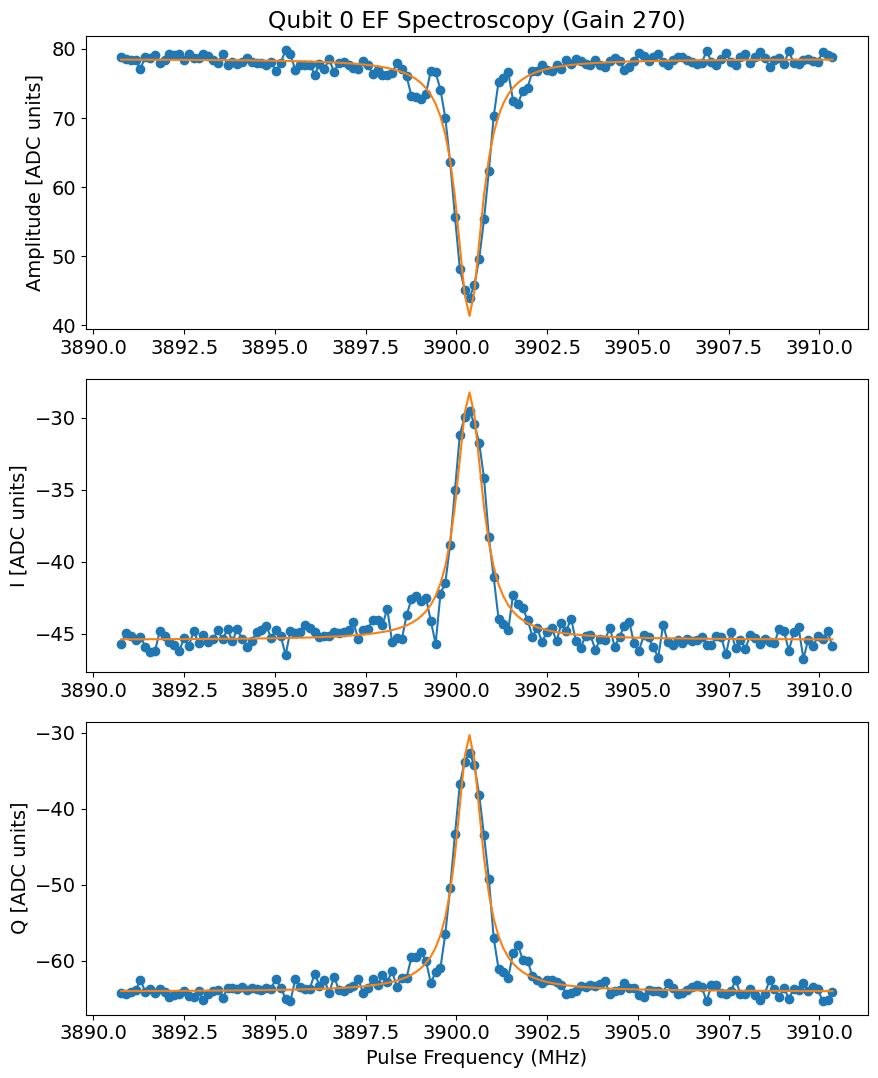

*Set qubit 0 f_ef to 3900.3584514047434*
[{'Qubit freq': 4126.453954862341, 'Pi pulse len': 0.015, 'Pi pulse gain': 28871, 'T1': 60.49066988941736, 'T1 err': 1.057140682499223, 'T2R': 11.034850330887265, 'T2R err': 0.9342254693273075, 'T2E': 19.028636662303455, 'T2E err': 0.6408222772603099, 'Qubit EF freq': 3900.3584514047434}, {}, {}, {}]


In [127]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = qEFspec2.analyze(data=temp_data, fit=True)

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    qEFspec2.analyze(fit=True, signs=[1, sign, sign])
    fit_err_i = qEFspec2.data['fit_err_avgi'][2][2]
    fit_err_q = qEFspec2.data['fit_err_avgq'][2][2]
    if fit_err_i < best_fit_err_i:
        best_signs[1] = sign
        best_fit_err_i = fit_err_i
    if fit_err_q < best_fit_err_q:
        best_signs[2] = sign
        best_fit_err_q = fit_err_q
    # except: continue
if best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qEFspec2.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qEFspec2.analyze(fit=True, signs=best_signs)
qEFspec2.display(fit=True, signs=best_signs)

qEFspec2_fit, qEFspec2_fit_err = meas.fitting.get_best_fit(qEFspec2.data)

yaml_cfg.device.qubit.f_ef[qubit_i] = qEFspec2_fit[2]
qubitEF_hwhm = qEFspec2_fit[3]
print(f'*Set qubit {qubit_i} f_ef to {yaml_cfg.device.qubit.f_ef[qubit_i]}*')

results_Qi.update({'Qubit EF freq':yaml_cfg.device.qubit.f_ef[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(all_results)

In [128]:
if save_data: saved_files.append(qEFspec2.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230927\00001_qubit_EF_spectroscopy_qubit0.h5


## Length EF Rabi

In [129]:
lengthrabiEF = meas.LengthRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabiEF_qubit{qubit_i}",
    config_file=config_path,
)
lengthrabiEF.cfg = AttrDict(deepcopy(yaml_cfg))

lengthrabiEF.cfg.expt = dict(
    start=soc.cycles2us(3), # pulse length (sigma) [us]
    step=soc.cycles2us(1), # [us]
    # step=0.001,
    expts=121,
    reps=3000,
    gain=yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i], # qubit gain [DAC units],
    pulse_type='gauss',
    checkZZ=False,
    checkEF=True, 
    qubits=[qubit_i],
)
# lengthrabiEF.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]

import Pyro4.util
try:
    lengthrabiEF.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/121 [00:00<?, ?it/s]

Decay from avgi [us] 0.32442554602675283
Pi length from avgi data [us]: 0.011565023343933287
	Pi/2 length from avgi data [us]: 0.0057825116719666435

Decay from avgq [us] 0.3435830766737515
Pi length from avgq data [us]: 0.011580569230943841
Pi/2 length from avgq data [us]: 0.0057902846154719205


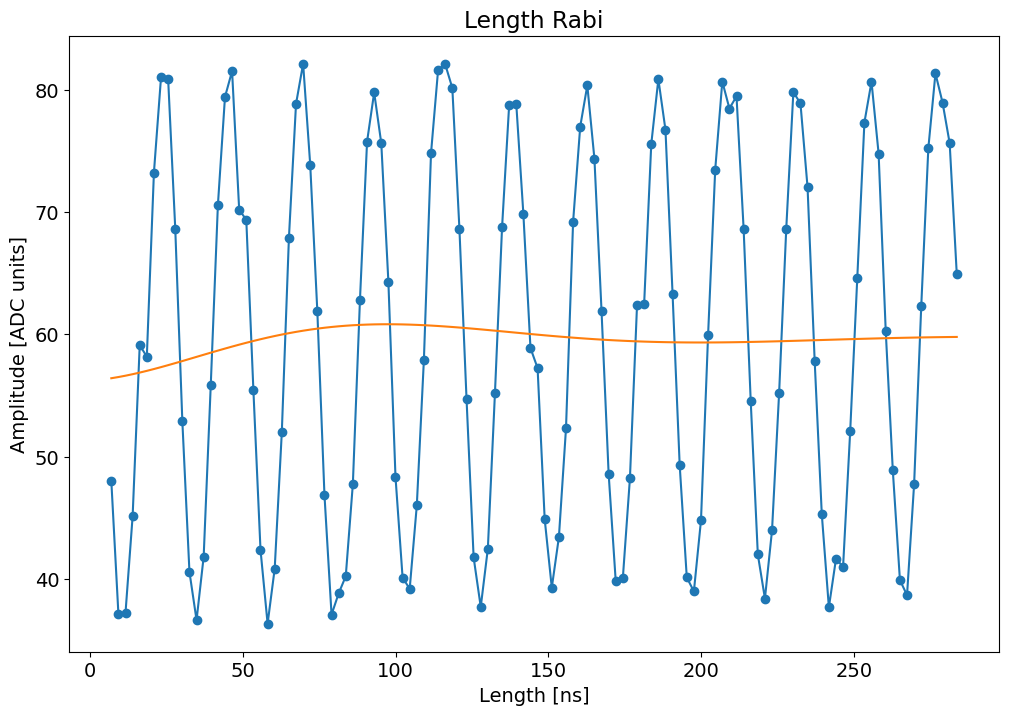

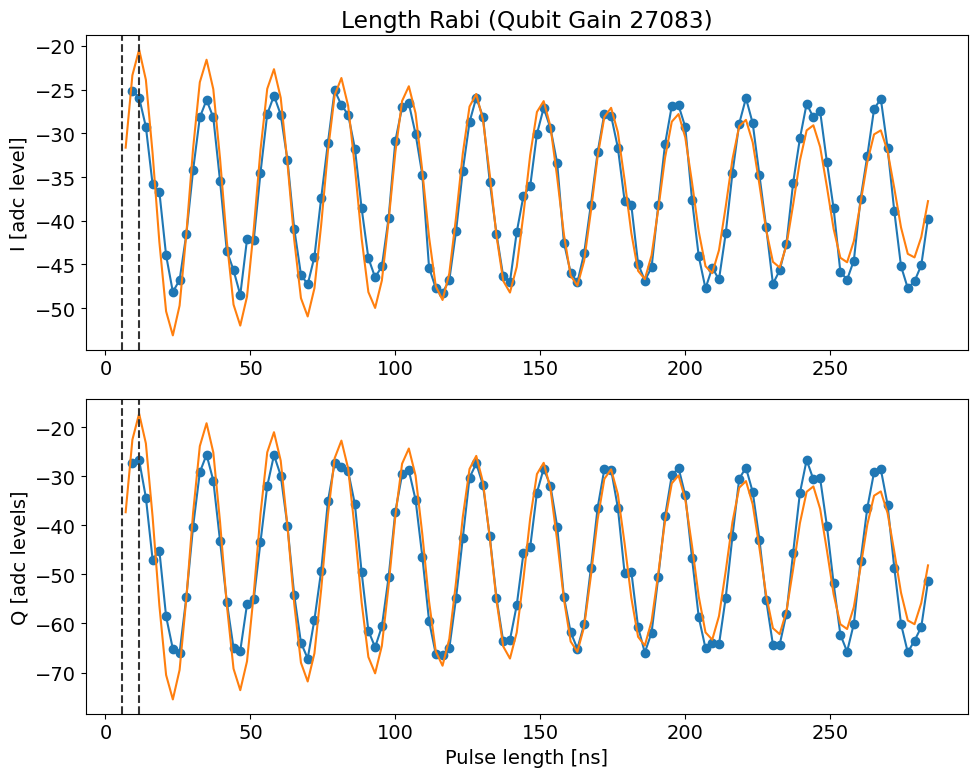

Will use sigma 0.015 for amplitude rabi EF


In [130]:
# # TESTING
# # lengthrabiEF = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# lengthrabiEF.data = temp_data

lengthrabiEF.analyze(fit=True)

lengthrabiEF_fit, lengthrabiEF_fit_err = meas.fitting.get_best_fit(lengthrabiEF.data) #, fitfunc=fitter.decaysin)

lengthrabiEF.display(fit=True)
p = lengthrabiEF_fit
if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_lenEF = (1/2 - p[2]/180)/2/p[1]
else: pi_lenEF = (3/2 - p[2]/180)/2/p[1]
pi_lenEF = np.max((0.9*pi_lenEF, 0.015)) # since we run the length rabi at a < max gain

lengthrabiEF_decay = p[3]

print(f'Will use sigma {pi_lenEF} for amplitude rabi EF')

In [132]:
if save_data: saved_files.append(lengthrabiEF.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230927\00000_length_rabiEF_qubit0.h5


## Amplitude EF Rabi

The EF pi pulse amplitude should be stored in <code>cfg.device.qubit.pulses.pi_ef.gain</code>.

In [133]:
amprabiEF = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="amp_rabi_EF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

amprabiEF.cfg = AttrDict(deepcopy(yaml_cfg))

span = min((32000, 1.5*yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]))
npts = 101

amprabiEF.cfg.expt = dict(
    start=1, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=100,
    rounds=30,
    sigma_test=pi_lenEF, # gaussian sigma for pulse length - default from cfg [us]
    pulse_type='gauss',
    checkZZ=False,
    checkEF=True, 
    qubits=[qubit_i],
)

# print(amprabiEF.cfg)
amprabiEF.go(analyze=False, display=False, progress=True, save=False)

gauss


  0%|          | 0/30 [00:00<?, ?it/s]

Pi gain from amps data [dac units]: 20766
	Pi/2 gain from amps data [dac units]: 10383
Pi gain from avgi data [dac units]: 20757
	Pi/2 gain from avgi data [dac units]: 10378
Pi gain from avgq data [dac units]: 20742
	Pi/2 gain from avgq data [dac units]: 10371


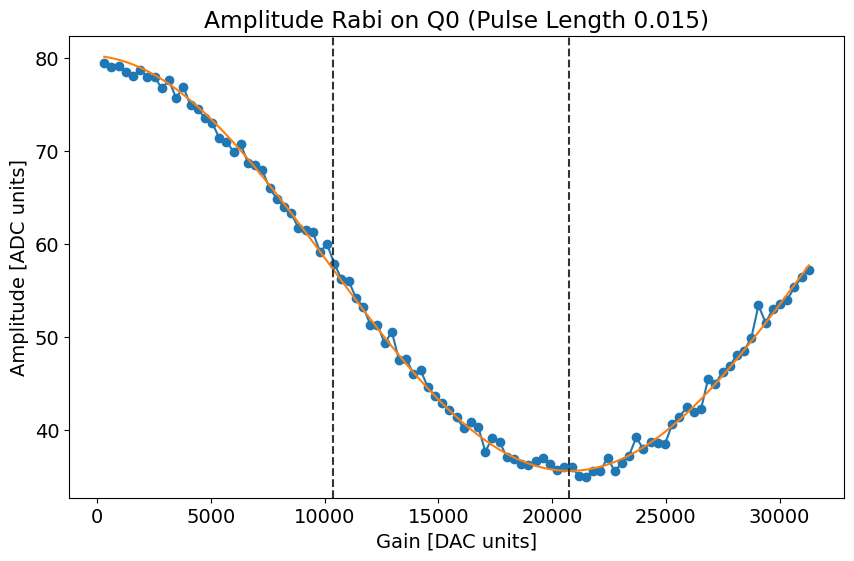

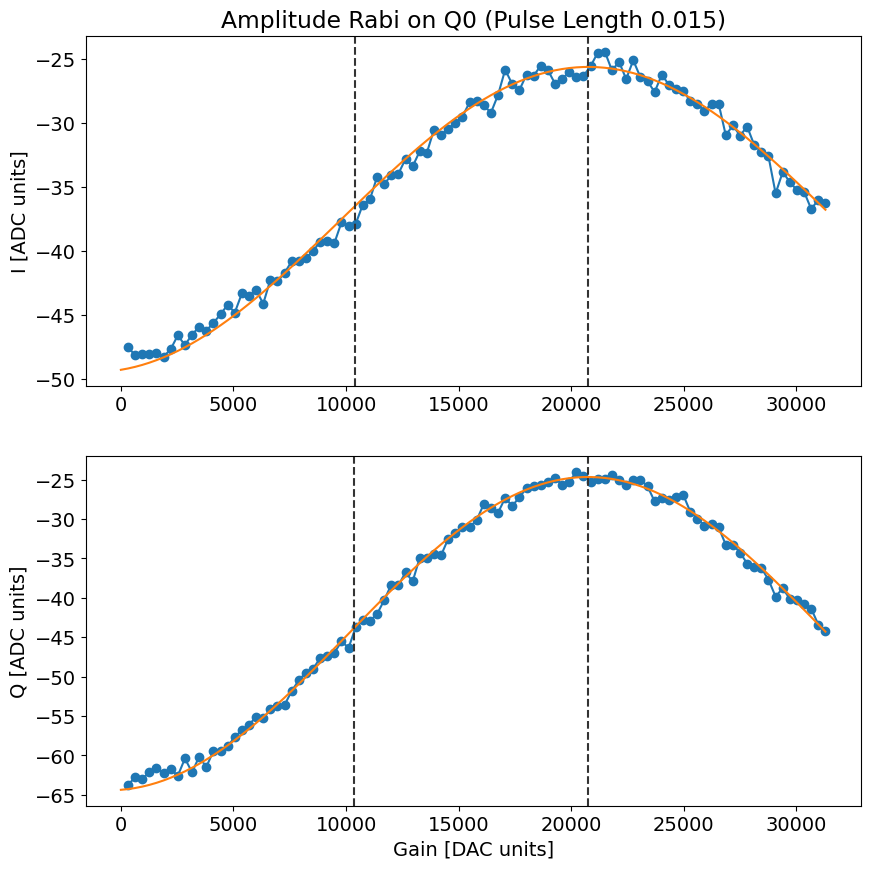

*Set EF pi pulse sigma for qubit 0 to 0.015*
*Set EF pi pulse gain for qubit 0 to 20742*
[{'Qubit freq': 4126.453954862341, 'Pi pulse len': 0.015, 'Pi pulse gain': 28871, 'T1': 60.49066988941736, 'T1 err': 1.057140682499223, 'T2R': 11.034850330887265, 'T2R err': 0.9342254693273075, 'T2E': 19.028636662303455, 'T2E err': 0.6408222772603099, 'Qubit EF freq': 3900.3584514047434, 'EF pi pulse len': 0.015, 'EF pi pulse gain': 20742}, {}, {}, {}]


In [134]:
# TESTING
# amprabiEF = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_EF_qubit1.h5')
# amprabiEF.data = temp_data

# amprabiEF.analyze(fit=False)
# amprabiEF.display(fit=False)

amprabiEF.analyze(fit=True)

amprabiEF_fit, amprabiEF_fit_err = meas.fitting.get_best_fit(amprabiEF.data)

p = amprabiEF_fit

if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
else: pi_gain = (3/2 - p[2]/180)/2/p[1]

if pi_gain > 32000:
    amprabiEF.display(fit=False)
    print('WARNING: Fit pi pulse gain is long, please double check!')
    pi_gain = 30000
else: amprabiEF.display(fit=True)

yaml_cfg.device.qubit.pulses.pi_ef.sigma[qubit_i] = amprabiEF.cfg.expt.sigma_test
print(f'*Set EF pi pulse sigma for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ef.sigma[qubit_i]}*')
yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i] = int(pi_gain)
print(f'*Set EF pi pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]}*')
results_Qi.update({'EF pi pulse len':yaml_cfg.device.qubit.pulses.pi_ef.sigma[qubit_i]})
results_Qi.update({'EF pi pulse gain':yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]})
print(all_results)

In [135]:
if save_data: saved_files.append(amprabiEF.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230927\00000_amp_rabi_EF_qubit0.h5


## Qubit temperature

In [141]:
amprabiEF2 = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="amp_rabi_EF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

amprabiEF2.cfg = AttrDict(deepcopy(yaml_cfg))

span = min((32000, 1.25*yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]))
npts = 101

amprabiEF2.cfg.expt = dict(
    start=1, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=100,
    rounds=60,
    sigma_test=pi_lenEF, # gaussian sigma for pulse length - default from cfg [us]
    pulse_ge=False, # set to false when measuring qubit temp
    pulse_type='gauss',
    checkZZ=False,
    checkEF=True, 
    qubits=[qubit_i],
)

# print(amprabiEF2.cfg)
amprabiEF2.go(analyze=False, display=False, progress=True, save=False)

gauss


  0%|          | 0/60 [00:00<?, ?it/s]

yscale normal: 44.76018961788129
yscale no pulse: 1.5274503064520886
Pi gain from amps data [dac units]: 27209
	Pi/2 gain from amps data [dac units]: 13604
Pi gain from avgi data [dac units]: 55915
	Pi/2 gain from avgi data [dac units]: 27957
Pi gain from avgq data [dac units]: 29466
	Pi/2 gain from avgq data [dac units]: 14733


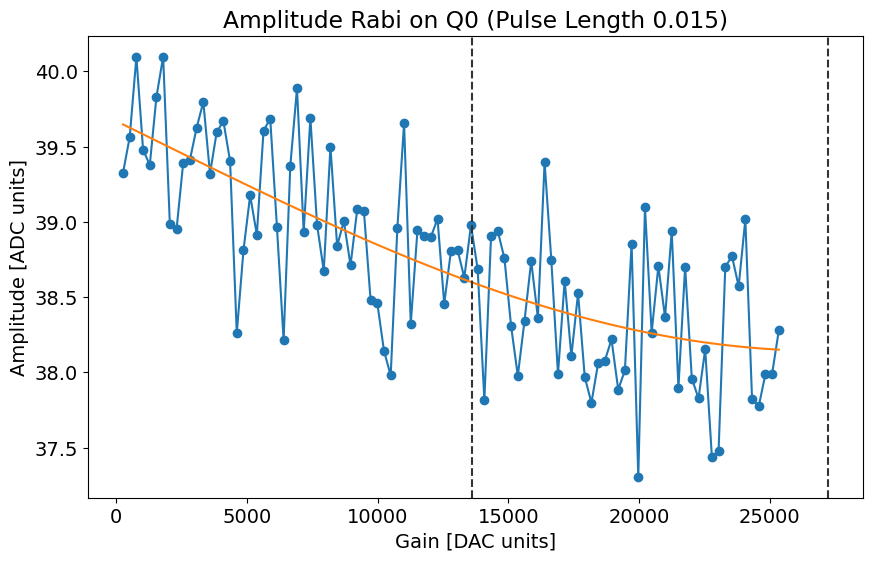

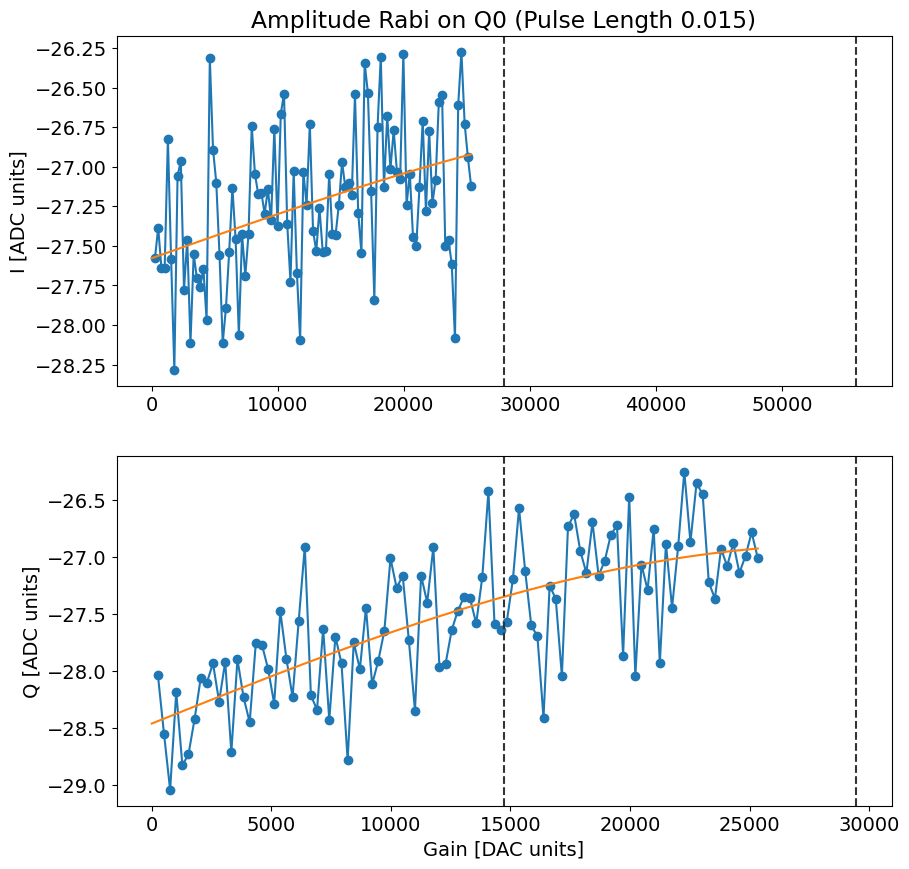

Qubit temp [mK]: 58.63085161452519
[{'Qubit freq': 4126.453954862341, 'Pi pulse len': 0.015, 'Pi pulse gain': 28871, 'T1': 60.49066988941736, 'T1 err': 1.057140682499223, 'T2R': 11.034850330887265, 'T2R err': 0.9342254693273075, 'T2E': 19.028636662303455, 'T2E err': 0.6408222772603099, 'Qubit EF freq': 3900.3584514047434, 'EF pi pulse len': 0.015, 'EF pi pulse gain': 20742, 'Qubit temp [mK]': 58.63085161452519}, {}, {}, {}]


In [142]:
# TESTING
# amprabiEF2 = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_EF_qubit1.h5')
# amprabiEF2.data = temp_data

# amprabiEF2.analyze(fit=False)
# amprabiEF2.display(fit=False)

amprabiEF2.analyze(fit=True)

amprabiEF2_fit, amprabiEF2_fit_err = meas.fitting.get_best_fit(amprabiEF2.data)

# NATURAL CONSTANTS
h = 6.62607015e-34
fge = 1e6*(amprabiEF2.cfg.device.qubit.f_ge[qubit_i] + amprabiEF2.cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i])
kB = 1.380649e-23
################

amprabiEF_amps = amprabiEF.data['amps']
p = amprabiEF.data['fit_amps']
# efamp_normal = p[0]
efamp_normal = max(amprabiEF.data['amps']) - min(amprabiEF.data['amps'])

amprabiEF2_amps = amprabiEF2.data['amps']
p = amprabiEF2.data['fit_amps']
fit_vals = meas.fitting.sinfunc(amprabiEF.data['xpts'], *p)
efamp_nopulse = max(fit_vals) - min(fit_vals)

print('yscale normal:', efamp_normal)
print('yscale no pulse:', efamp_nopulse)

temp = 1e3*-h*fge/(kB*np.log(efamp_nopulse/efamp_normal))

amprabiEF2.display(fit=True)

print('Qubit temp [mK]:', temp)
results_Qi.update({'Qubit temp [mK]':temp})
print(all_results)

In [143]:
if save_data: saved_files.append(amprabiEF2.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230927\00001_amp_rabi_EF_qubit0.h5


## EF Ramsey Fringe
Update the ef frequency in <code>cfg.qubit.f_ef</code>.

In [357]:
# yaml_cfg.device.qubit.f_ge[qubit_i] = 145.572034953271
# qubitEF_hwhm = 7
# short_T1 = False

In [144]:
ramseyEF_freq = max((min((np.abs(np.ceil(qubitEF_hwhm)), 3)), 2))

t2EFr = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="ramseyEF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

t2EFr.cfg = AttrDict(deepcopy(yaml_cfg))

t2EFr.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(10), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # step=0.05, # [us]
    expts=151,
    ramsey_freq=ramseyEF_freq, # [MHz]
    checkZZ=False,
    checkEF=True,
    reps=100,
    rounds=30,
    qubits=[qubit_i],
)

import Pyro4.util
try:
    t2EFr.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/30 [00:00<?, ?it/s]

Current pi pulse frequency: 3900.3584514047434
Fit frequency from amps [MHz]: 1.9034869205694989 +/- 0.006760527990734435
Suggested new pi pulse frequencies from fit amps [MHz]:
 	3900.454964484174
 	3896.454964484174
T2 Ramsey from fit amps [us]: 2.0841687153789143
Current pi pulse frequency: 3900.3584514047434
Fit frequency from I [MHz]: 1.904749341078304 +/- 0.006369859096073707
Suggested new pi pulse frequency from fit I [MHz]:
 	3900.453702063665
 	3896.453702063665
T2 Ramsey from fit I [us]: 2.411801581225611
Fit frequency from Q [MHz]: 1.9046195415854208 +/- 0.006026229913721722
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3900.453831863158
 	3896.453831863158
T2 Ramsey from fit Q [us]: 2.373020286601212


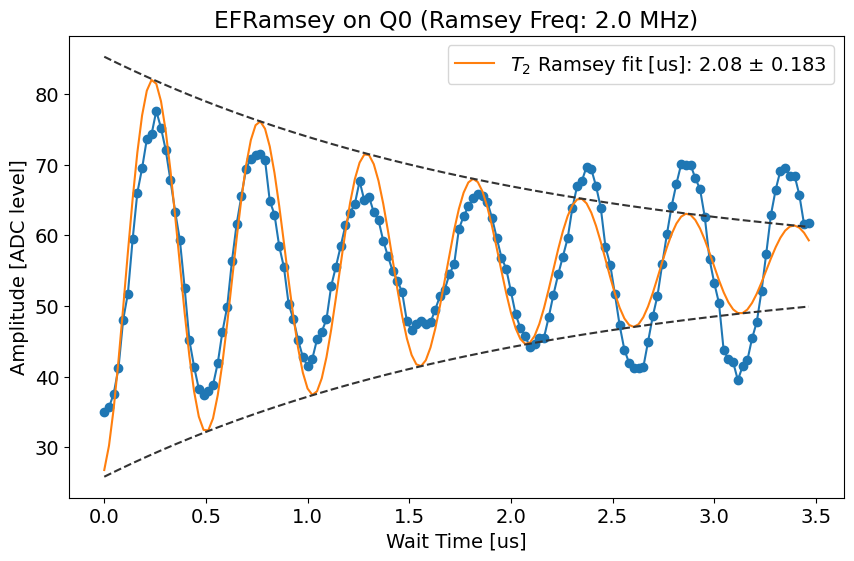

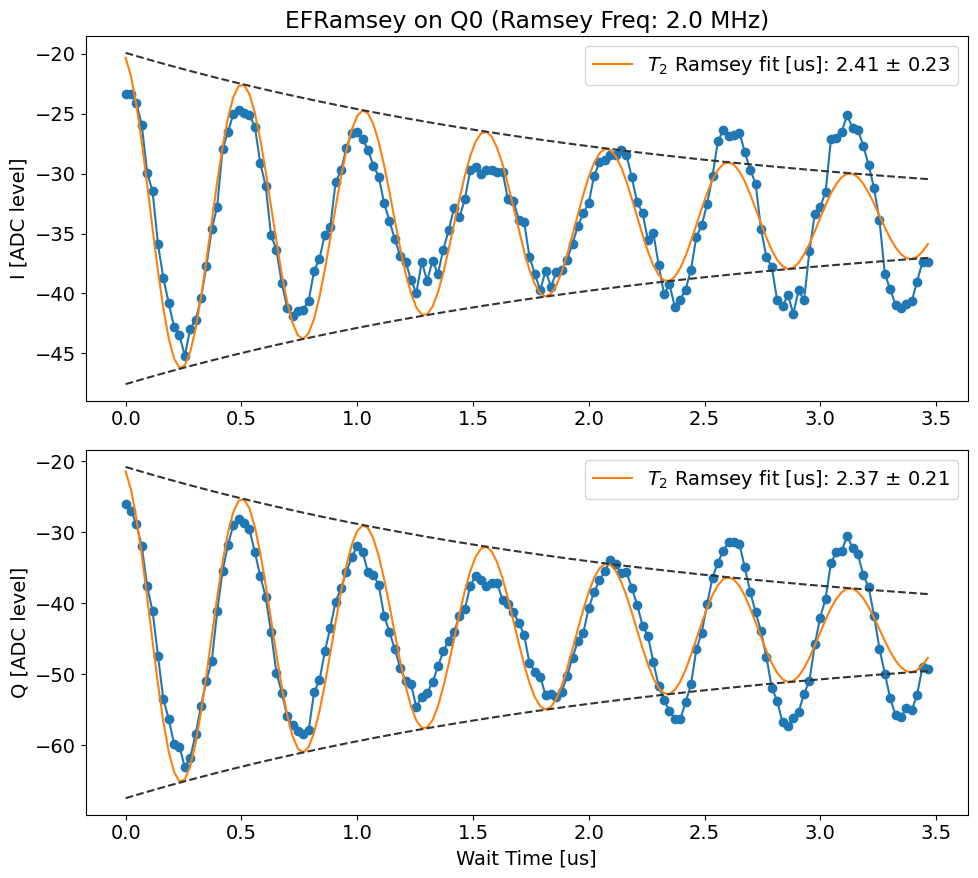

*Set qubit 0 EF freq to 3900.453831863158*
[{'Qubit freq': 4126.453954862341, 'Pi pulse len': 0.015, 'Pi pulse gain': 28871, 'T1': 60.49066988941736, 'T1 err': 1.057140682499223, 'T2R': 11.034850330887265, 'T2R err': 0.9342254693273075, 'T2E': 19.028636662303455, 'T2E err': 0.6408222772603099, 'Qubit EF freq': 3900.453831863158, 'EF pi pulse len': 0.015, 'EF pi pulse gain': 20742, 'Qubit temp [mK]': 58.63085161452519}, {}, {}, {}]


In [154]:
# # TESTING
# # t2EFr = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
# t2EFr.data = temp_data

t2EFr.analyze(fit=True)
t2EFr_fit, t2EFr_fit_err, t2EFr_adjust = meas.fitting.get_best_fit(t2EFr.data, get_best_data_params=['f_adjust_ramsey'])
old_qubit_freq = t2EFr.cfg.device.qubit.f_ef[qubit_i]

if not isinstance(t2EFr_fit, (list, np.ndarray)):
    t2EFr.display(fit=False)
    assert False, 'Fit failed, please manually fix!'
t2EFr.display(fit=True)
yaml_cfg.device.qubit.f_ef[qubit_i] = old_qubit_freq + t2EFr_adjust[0]
alt_qubit_freq = old_qubit_freq + t2EFr_adjust[1]
print(f'*Set qubit {qubit_i} EF freq to {yaml_cfg.device.qubit.f_ef[qubit_i]}*')
results_Qi.update({'Qubit EF freq':yaml_cfg.device.qubit.f_ef[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(all_results)

In [271]:
if save_data: saved_files.append(t2EFr.save_data())

## EF Ramsey Fringe Round 2
Update the ef frequency in <code>cfg.qubit.f_ef</code>.

In [ ]:
# yaml_cfg.device.qubit.f_ge[qubit_i] = 145.572034953271
# qubitEF_hwhm = 7
# short_T1 = False

In [151]:
t2EFr_2 = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="ramseyEF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

t2EFr_2.cfg = AttrDict(deepcopy(yaml_cfg))

t2EFr_2.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(30), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # step=0.05, # [us]
    expts=151,
    ramsey_freq=ramseyEF_freq/10, # [MHz]
    checkZZ=False,
    checkEF=True,
    reps=100,
    rounds=30,
    qubits=[qubit_i],
)

import Pyro4.util
try:
    t2EFr_2.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/30 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 2.3893333333333335, which is out of bounds 0.009621476510067114 to 1.443221476510067. Instead init to 0.726421476510067
Current pi pulse frequency: 3900.37580503521
Fit frequency from amps [MHz]: 0.5061490967122502 +/- 0.014867683781466573
Suggested new pi pulse frequencies from fit amps [MHz]:
 	3900.069655938498
 	3899.6696559384977
T2 Ramsey from fit amps [us]: 3.118024553571429
Current pi pulse frequency: 3900.37580503521
Fit frequency from I [MHz]: 0.1392748317129977 +/- 0.0046446669367947516
Suggested new pi pulse frequency from fit I [MHz]:
 	3900.4365302034967
 	3900.036530203497
T2 Ramsey from fit I [us]: 5.012132844555291
Fit frequency from Q [MHz]: 0.13209081959173652 +/- 0.003990277917057865
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3900.443714215618
 	3900.043714215618
T2 Ramsey from fit Q [us]: 5.549895739093374


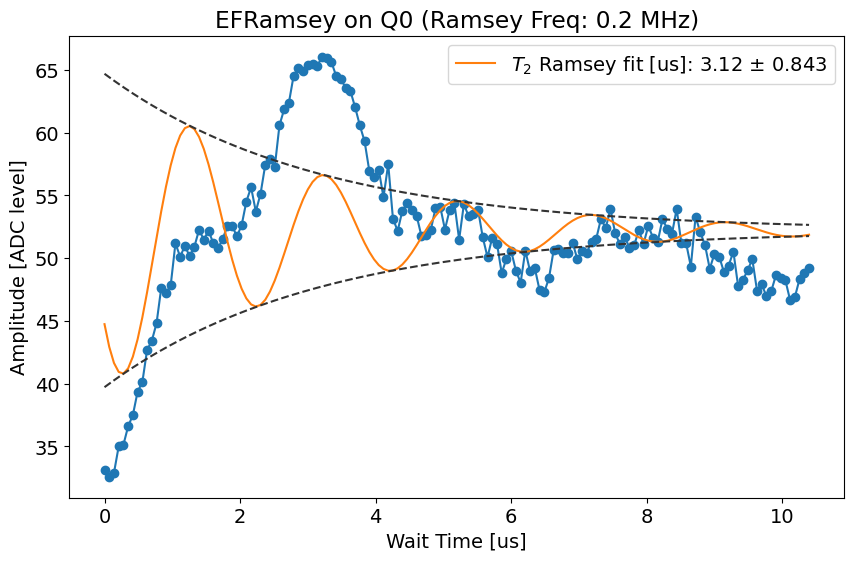

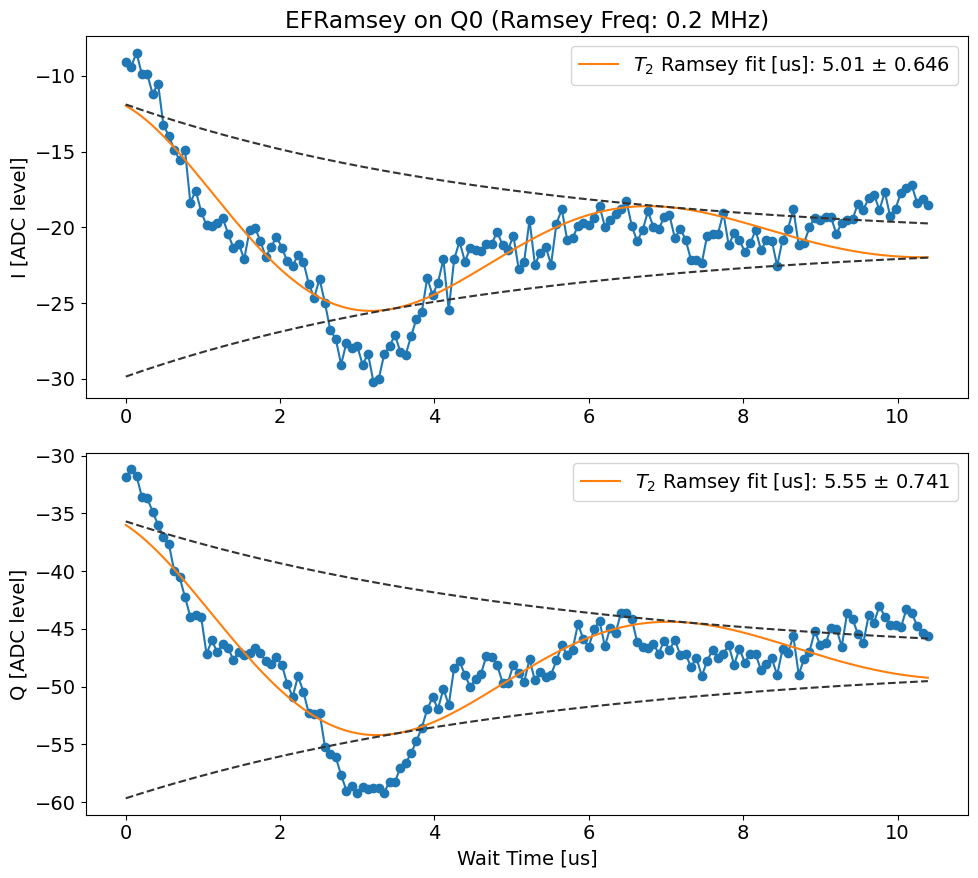

*Set qubit 0 EF freq to 3900.443714215618*
{'Qubit freq': 4126.453954862341, 'Pi pulse len': 0.015, 'Pi pulse gain': 28871, 'T1': 60.49066988941736, 'T1 err': 1.057140682499223, 'T2R': 11.034850330887265, 'T2R err': 0.9342254693273075, 'T2E': 19.028636662303455, 'T2E err': 0.6408222772603099, 'Qubit EF freq': 3900.443714215618, 'EF pi pulse len': 0.015, 'EF pi pulse gain': 20742, 'Qubit temp [mK]': 58.63085161452519}


In [152]:
# # TESTING
# # t2EFr_2 = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
# t2EFr_2.data = temp_data

t2EFr_2.analyze(fit=True)
t2EFr_2_fit, t2EFr_2_fit_err, t2EFr_2_adjust = meas.fitting.get_best_fit(t2EFr_2.data, get_best_data_params=['f_adjust_ramsey'])
old_qubit_freq = t2EFr_2.cfg.device.qubit.f_ef[qubit_i]

if not isinstance(t2EFr_2_fit, (list, np.ndarray)):
    t2EFr_2.display(fit=False)
    assert False, 'Fit failed, please manually fix!'
t2EFr_2.display(fit=True)

if t2EFr_2_adjust[0] > ramseyEF_freq/10:
    print('WARNING: your EF frequency is not converging!')
else:
    yaml_cfg.device.qubit.f_ef[qubit_i] = old_qubit_freq + t2EFr_2_adjust[0]
    alt_qubit_freq = old_qubit_freq + t2EFr_2_adjust[1]
    print(f'*Set qubit {qubit_i} EF freq to {yaml_cfg.device.qubit.f_ef[qubit_i]}*')
    results_Qi.update({'Qubit EF freq':yaml_cfg.device.qubit.f_ef[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
    print(results_Qi)

In [157]:
if save_data: saved_files.append(t2EFr.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230927\00000_ramseyEF_qubit0.h5


# Resonator chi shift (e/f)

In [116]:
rspecEF_chi = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_chi_qubit{qubit_i}",
    config_file=config_path,
)
rspecEF_chi.cfg = AttrDict(deepcopy(yaml_cfg))

span = 5 # MHz
npts = 151
rspecEF_chi.cfg.expt = dict(
    start=rspecEF_chi.cfg.device.readout.frequency[qubit_i]-abs(results_Qi['Res chi shift (e - g)'])-span, # [MHz]
    # start=rspecEF_chi.cfg.device.readout.frequency[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=3000,
    pulse_e=True, # add ge pi pulse prior to measurement
    pulse_f=True, # add ef pi pulse prior to measurement
    qubit=qubit_i,
)
# rspecEF_chi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]
rspecEF_chi.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/151 [00:00<?, ?it/s]

[-811.3625297153883, 5000, 1000, 0, 17.03715941066355, 326.477619610652]
[-8.03285761e+02 -3.03561876e+05 -1.27177254e+01  5.91794716e+00
 -1.27356982e+02  3.11150862e+02]

Freq with minimum transmission: -813.4817350134015
Freq with maximum transmission: -808.9453111723419
From fit:
	f0: -803.2857613940467
	Qi: -303561.8763070908
	Qe: -12.71772541526503
	Q0: -12.717192628454415
	kappa [MHz]: 63.165337261363334
	phi [radians]: 5.917947164978501


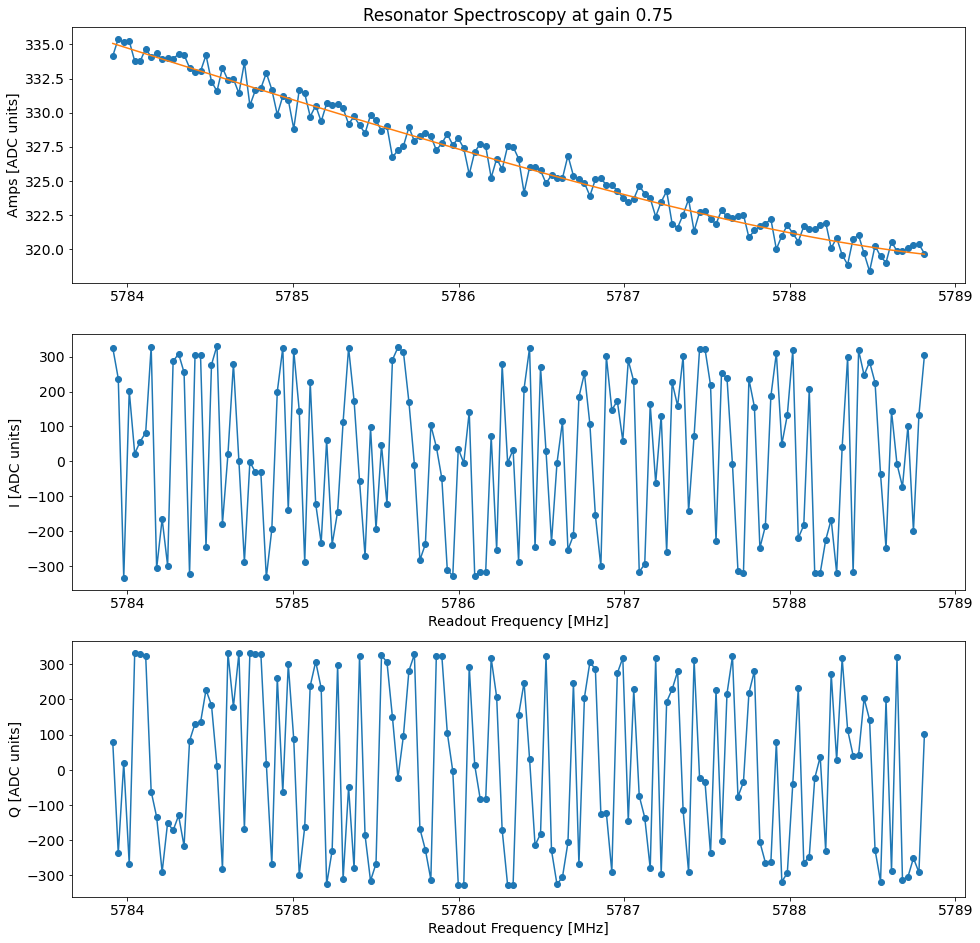

[{'Res freq': 7688.874258045896, 'Res kappa': 0.9756441096550745, 'Qubit freq': 4823.861508259508, 'Pi pulse len': 0.03956011335259716, 'Pi pulse gain': 22779, 'T1': 97.14424019836063, 'T1 err': 4.6355555889821245, 'T2R': 8.312336278065233, 'T2R err': 0.3957274632565941, 'T2E': 17.688832442781287, 'T2E err': 0.7326171278801736, 'Qubit EF freq': 4640.557961214359, 'EF pi pulse len': 0.025, 'EF pi pulse gain': 16093}, {'Res freq': 5783.299615808103, 'Res kappa': 0.30608491399697296, 'Qubit freq': 3472.403818423059, 'Pi pulse len': 0.020738980081829388, 'Pi pulse gain': 23185, 'T1': 52.567929832315315, 'T1 err': 0.6768379550408044, 'T2R': 1.8746149564710788, 'T2R err': 0.1533478261277939, 'T2E': 15.873701812556538, 'T2E err': 0.3698073838910515, 'Res chi shift (e - g)': -0.5463576158940668, 'Qubit EF freq': 603.7170605500958, 'EF pi pulse len': 0.025, 'EF pi pulse gain': 2680, 'Res chi shift (f - g)': 5.546357615894067}, {}, {}]


In [117]:
# # TESTING
# # rspecEF_chi = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# temp_data, attrs = prev_data(expt_path, '00001_resonator_spectroscopy_qubit2.h5')
# rspecEF_chi.data = temp_data

rspecEF_chi.analyze(fit=True)
rspecEF_chi_fit = rspecEF_chi.data['fit']
rspecEF_chi.display(fit=True)
# res_freq_f = rspecEF_chi_fit[0]
res_freq_f = rspecEF_chi.data['xpts'][np.argmin(rspecEF_chi.data['amps'])]
results_Qi.update({'Res chi shift (f - g)': yaml_cfg.device.readout.lo_sideband[qubit_i]*(res_freq_f - yaml_cfg.device.readout.frequency[qubit_i])})
# res_freq_f = 6953.5
# results_Qi.update({'Res chi shift (e - g)': res_freq_e - (5925 + yaml_cfg.device.readout.lo_sideband[qubit_i]*(yaml_cfg.hw.soc.dacs.readout.mixer_freq + yaml_cfg.device.readout.frequency[qubit_i]))})
print(all_results)

In [118]:
if save_data: saved_files.append(rspecEF_chi.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data_221007\00000_resonator_spectroscopy_chi_qubit1.h5


# Single Shot

## Single shot optimization

In [20]:
results_Qi['Res kappa'] = 0.2
# print(results_Qi['Res kappa'])

In [57]:
shotopt = meas.SingleShotOptExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_opt_qubit{qubit_i}",
    config_file=config_path,
)
shotopt.cfg = AttrDict(deepcopy(yaml_cfg))

# span_f = 2*abs(results_Qi['Res chi shift (f - g)']) # MHz
# span_f = 2*abs(results_Qi['Res chi shift (e - g)']) # MHz

# span_f = 2*abs(results_Qi['Res kappa']) # MHz
# npts_f = 15

span_f = 3*abs(results_Qi['Res kappa']) # MHz
npts_f = 20

span_gain = 0.0
npts_gain = 1
# span_gain = 0.08
# npts_gain = 8

# span_len = 8 # us
# npts_len = 2
span_len = 8 # us
npts_len = 1

shotopt.cfg.expt = dict(
    reps=15000,
    qubit=qubit_i,

    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] - 0.75*span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] + 0.25*span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i],
    start_f=shotopt.cfg.device.readout.frequency[qubit_i] - span_f/2, # [MHz]
    step_f=span_f/npts_f,
    expts_f=npts_f,

    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i]-span_gain/2),
    start_gain=0.03,
    step_gain=span_gain/npts_gain,
    expts_gain=npts_gain + 1,
    # start_gain=0.25,
    # step_gain=0,
    # expts_gain=1,

    start_len=5,
    step_len=0,
    expts_len=1,
    # start_len=2,
    # step_len=span_len/npts_len,
    # expts_len=npts_len + 1,
)

print(shotopt.cfg)

shotopt.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'f_ge': [4125.896624486673, 3452.4896245260456, 4780.416037811193, 4395.282433405918], 'f_ef': [3900.453831863158, 3354.521139701014, 4590.177049031502, 4221.931929269591], 'f_Q1_ZZ': [3449.8479407210834, 0, 3453.9100412763405, 3453.7081320189013], 'f_Q_ZZ1': [4124.290504319941, 0, 4778.502356522805, 4393.211594838028], 'f_EgGf': [2681.44696031, -1, 2028.1, 2407.9], 'f_EgGf_Q': [-1, -1, 5913.75, 5163.75], 'gs': [54.233867058381975, 56.612917931142945, 42.87162116341841, 5.275712018852002, 2.7385639790041876, 6.807578931629736], 'ZZs': [0.0, -5.11947537, -0.14716401, -0.55347891, -5.11803281, 0.0, -1.17332055, -1.13249508, -0.17856354, -1.0686238, 0.0, -0.50772987, -0.64108991, -1.26309732, -0.62827282, 0.0], 'T1': [60, 57, 55, 50], 'pulses': {'pi_ge': {'gain': [29351, 26882, 3021, 2572], 'sigma': [0.015, 0.1, 0.020886833661091352, 0.015], 'type': 'gauss'}, 'pi_ef': {'gain': [20742, 26000, 1633, 1669], 'sigma': [0.015, 0.1, 0.015, 0.015], 'type': 'gauss'}, 'pi_Q1_Z

  0%|          | 0/20 [00:00<?, ?it/s]

freq: -70.07520019711461, gain: 0.03, len: 5
	fid ge [%]: 54.361812060402016
freq: -70.07520019711461, gain: 0.03, len: 5
	fid ge [%]: 55.47703180212014
freq: -70.06258704475339, gain: 0.03, len: 5
	fid ge [%]: 65.27550918363946
freq: -70.06258704475339, gain: 0.03, len: 5
	fid ge [%]: 64.39095939729316
freq: -70.04997389239215, gain: 0.03, len: 5
	fid ge [%]: 50.496699779985335
freq: -70.04997389239215, gain: 0.03, len: 5
	fid ge [%]: 50.60835361178706
freq: -70.03736074003092, gain: 0.03, len: 5
	fid ge [%]: 62.9775318354557
freq: -70.03736074003092, gain: 0.03, len: 5
	fid ge [%]: 65.00883362778758
freq: -70.0247475876697, gain: 0.03, len: 5
	fid ge [%]: 61.255375179172646
freq: -70.0247475876697, gain: 0.03, len: 5
	fid ge [%]: 58.581952731757724
freq: -70.01213443530845, gain: 0.03, len: 5
	fid ge [%]: 77.09590319677324
freq: -70.01213443530845, gain: 0.03, len: 5
	fid ge [%]: 72.28907630254342
freq: -69.99952128294723, gain: 0.03, len: 5
	fid ge [%]: 15.394359623974932
freq: -69.

(9, 1, 0)
[-70.0752002  -70.06258704 -70.04997389 -70.03736074 -70.02474759
 -70.01213444 -69.99952128 -69.98690813 -69.97429498 -69.96168183
 -69.94906867 -69.93645552 -69.92384237 -69.91122922 -69.89861606
 -69.88600291 -69.87338976 -69.86077661 -69.84816345 -69.8355503 ]
[0.03 0.03]
[5]
Max fidelity 77.2584838989266 %
Set params: 
 angle (deg) 38.15972862919367 
 threshold -144.9303276576543 
 freq [Mhz] -69.96168182586354 
 gain [dac units] 0.03 
 readout length [us] 5


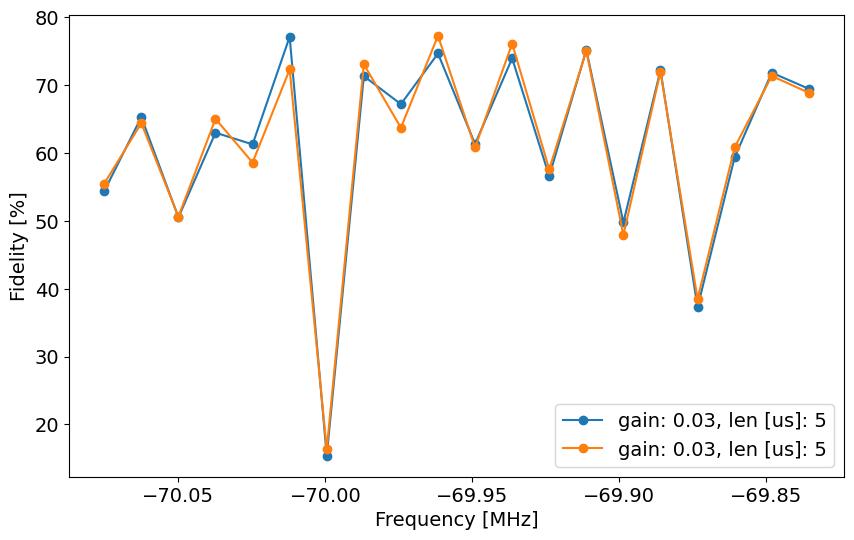

[[[0.54361812]
  [0.55477032]]

 [[0.65275509]
  [0.64390959]]

 [[0.504967  ]
  [0.50608354]]

 [[0.62977532]
  [0.65008834]]

 [[0.61255375]
  [0.58581953]]

 [[0.77095903]
  [0.72289076]]

 [[0.1539436 ]
  [0.16353878]]

 [[0.71311421]
  [0.73049102]]

 [[0.67182239]
  [0.6370879 ]]

 [[0.74642488]
  [0.77258484]]

 [[0.61302043]
  [0.60802027]]

 [[0.73929131]
  [0.76102537]]

 [[0.56561885]
  [0.57581919]]

 [[0.75162505]
  [0.75049168]]

 [[0.49754992]
  [0.47896526]]

 [[0.72184812]
  [0.7195866 ]]

 [[0.37255817]
  [0.3848795 ]]

 [[0.59341978]
  [0.6079536 ]]

 [[0.71815727]
  [0.71335711]]

 [[0.69442315]
  [0.68855629]]]


In [58]:
imax = shotopt.analyze()
shotopt.display()
print(shotopt.data['fid'])

freq_opt = shotopt.data['fpts'][imax[0]]
gain_opt = shotopt.data['gainpts'][imax[1]]
len_opt = shotopt.data['lenpts'][imax[2]]

In [306]:
if save_data: saved_files.append(shotopt.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230217\00000_single_shot_opt_qubit0.h5


next qubit

In [89]:
qubit_i = 0
results_Qi = all_results[qubit_i]
results_Qi['Res kappa'] = 0.2
# print(results_Qi['Res kappa'])

In [308]:
shotopt = meas.SingleShotOptExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_opt_qubit{qubit_i}",
    config_file=config_path,
)
shotopt.cfg = AttrDict(deepcopy(yaml_cfg))

# span_f = 2*abs(results_Qi['Res chi shift (f - g)']) # MHz
# span_f = 2*abs(results_Qi['Res chi shift (e - g)']) # MHz

# span_f = 2*abs(results_Qi['Res kappa']) # MHz
# npts_f = 15

span_f = 3*abs(results_Qi['Res kappa']) # MHz
npts_f = 20

# span_gain = 0.85
# npts_gain = 5
span_gain = 0.3
npts_gain = 2

span_len = 8 # us
npts_len = 1

shotopt.cfg.expt = dict(
    reps=20000,
    qubit=qubit_i,

    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] - 0.75*span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] + 0.25*span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i],
    start_f=shotopt.cfg.device.readout.frequency[qubit_i] - span_f/2, # [MHz]
    step_f=span_f/npts_f,
    expts_f=npts_f,

    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i]-span_gain/2),
    start_gain=0.65,
    # start_gain=0.10,
    step_gain=span_gain/npts_gain,
    expts_gain=npts_gain + 1,

    start_len=8,
    # step_len=span_len/npts_len,
    # expts_len=npts_len + 1,
    step_len=0
    expts_len=1,
)

print(shotopt.cfg)

shotopt.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [25.0, 96, 37, 58], 'f_ge': [140.53780501105496, 3463.808810074577, 801.6560698688288, 415.4550753130457], 'f_Q1_ZZ': [3459.6786038062905, 0, 3463.6713203864697, 3463.502866097378], 'f_ef': [-85.23280567900892, 3363.373743527249, 621.9460573302758, 243.19506598901376], 'f_EgGf': [2678.75, 0, 2016.3, 2395.2], 'ZZs': [0.0, -4.7126775455997745, -0.10534620937775685, -0.28344964409794215, -4.236078028296106, 0.0, -0.16869289545775246, -0.2784781391173965, 0.5146242128746508, -0.12676679271078228, 0.0, -0.06125637291711428, 3.0556426555347116, 2.6356995614617063, 3.312733462014023, 0.0], 'pulses': {'pi_ge': {'gain': [22171, 24842, 20682, 24647], 'sigma': [0.04075108068027949, 0.018, 0.047, 0.025], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [23923, 22558, 21770, 21903], 'sigma': [0.03626867745453954, 0.015, 0.018, 0.0166], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [21755, 0, 22230, 22495], 'sigma': [0.017798133875785653, 0, 0.01792220834421204, 

  0%|          | 0/20 [00:00<?, ?it/s]

freq: 88.10600000000001, gain: 0.65, len: 2.0
	fid ge [%]: 11.56028900722518
freq: 88.10600000000001, gain: 0.65, len: 6.0
	fid ge [%]: 16.100402510062754
freq: 88.10600000000001, gain: 0.65, len: 10.0
	fid ge [%]: 18.745468636715916
freq: 88.10600000000001, gain: 0.8, len: 2.0
	fid ge [%]: 13.435335883397084
freq: 88.10600000000001, gain: 0.8, len: 6.0
	fid ge [%]: 16.66041651041276
freq: 88.10600000000001, gain: 0.8, len: 10.0
	fid ge [%]: 21.835545888647214
freq: 88.10600000000001, gain: 0.95, len: 2.0
	fid ge [%]: 15.730393259831496
freq: 88.10600000000001, gain: 0.95, len: 6.0
	fid ge [%]: 20.906567992599445
freq: 88.10600000000001, gain: 0.95, len: 10.0
	fid ge [%]: 25.175629390734766
freq: 88.13600000000001, gain: 0.65, len: 2.0
	fid ge [%]: 11.135556777838893
freq: 88.13600000000001, gain: 0.65, len: 6.0
	fid ge [%]: 13.560678033901697
freq: 88.13600000000001, gain: 0.65, len: 10.0
	fid ge [%]: 17.20043001075027
freq: 88.13600000000001, gain: 0.8, len: 2.0
	fid ge [%]: 12.66031

(5, 2, 2)
[88.106 88.136 88.166 88.196 88.226 88.256 88.286 88.316 88.346 88.376
 88.406 88.436 88.466 88.496 88.526 88.556 88.586 88.616 88.646 88.676]
[0.65 0.8  0.95]
[ 2.  6. 10.]
Max fidelity 39.22098052451311 %
Set params: 
 angle (deg) 63.21344812253799 
 threshold 1684.1831138018324 
 freq [Mhz] 88.25600000000001 
 gain [dac units] 0.95 
 readout length [us] 10.0


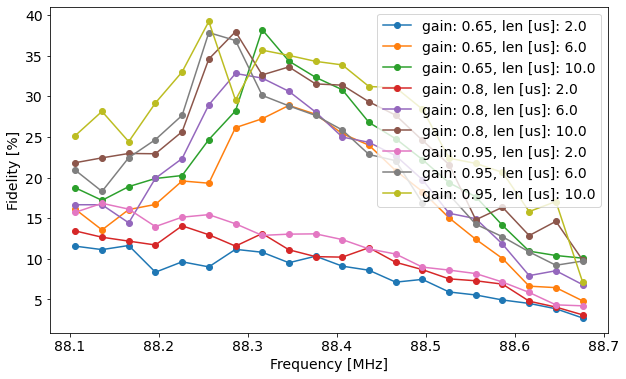

[[[0.11560289 0.16100403 0.18745469]
  [0.13435336 0.16660417 0.21835546]
  [0.15730393 0.20906568 0.25175629]]

 [[0.11135557 0.13560678 0.1720043 ]
  [0.12660317 0.16655416 0.22430561]
  [0.16835421 0.18300915 0.28151408]]

 [[0.11641164 0.16065402 0.18890472]
  [0.12180305 0.14435361 0.22970574]
  [0.16120403 0.22450561 0.24425611]]

 [[0.08355209 0.16695417 0.19890497]
  [0.11705585 0.19915498 0.22935573]
  [0.13970699 0.24675617 0.2918573 ]]

 [[0.09635241 0.19585979 0.20255506]
  [0.14065703 0.22345559 0.25651924]
  [0.15130378 0.27660692 0.33011651]]

 [[0.09010225 0.19310483 0.24675617]
  [0.12965648 0.28956448 0.34595865]
  [0.15440386 0.37850946 0.39220981]]

 [[0.11170279 0.26150654 0.28215705]
  [0.11565289 0.32816641 0.37963796]
  [0.14315358 0.36875922 0.29545739]]

 [[0.10810541 0.27245681 0.38205955]
  [0.13115328 0.32250806 0.32640816]
  [0.12885322 0.30120753 0.35690892]]

 [[0.09520238 0.28886444 0.34342576]
  [0.11115278 0.30620766 0.33625841]
  [0.13040326 0.288257

In [309]:
imax = shotopt.analyze()
shotopt.display()
print(shotopt.data['fid'])

freq_opt = shotopt.data['fpts'][imax[0]]
gain_opt = shotopt.data['gainpts'][imax[1]]
len_opt = shotopt.data['lenpts'][imax[2]]

In [310]:
if save_data: saved_files.append(shotopt.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230217\00000_single_shot_opt_qubit3.h5


next qubit

In [311]:
qubit_i = 1
results_Qi = all_results[qubit_i]
results_Qi['Res kappa'] = 0.2
# print(results_Qi['Res kappa'])

In [312]:
shotopt = meas.SingleShotOptExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_opt_qubit{qubit_i}",
    config_file=config_path,
)
shotopt.cfg = AttrDict(deepcopy(yaml_cfg))

# span_f = 2*abs(results_Qi['Res chi shift (f - g)']) # MHz
# span_f = 2*abs(results_Qi['Res chi shift (e - g)']) # MHz

# span_f = 2*abs(results_Qi['Res kappa']) # MHz
# npts_f = 15

span_f = 3*abs(results_Qi['Res kappa']) # MHz
npts_f = 20

# span_gain = 0.85
# npts_gain = 5
span_gain = 0.3
npts_gain = 2

span_len = 8 # us
npts_len = 2

shotopt.cfg.expt = dict(
    reps=20000,
    qubit=qubit_i,

    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] - 0.75*span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] + 0.25*span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i],
    start_f=shotopt.cfg.device.readout.frequency[qubit_i] - span_f/2, # [MHz]
    step_f=span_f/npts_f,
    expts_f=npts_f,

    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i]-span_gain/2),
    start_gain=0.65,
    # start_gain=0.10,
    step_gain=span_gain/npts_gain,
    expts_gain=npts_gain + 1,

    start_len=2,
    step_len=span_len/npts_len,
    expts_len=npts_len + 1,
)

print(shotopt.cfg)

shotopt.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [25.0, 96, 37, 58], 'f_ge': [140.53780501105496, 3463.808810074577, 801.6560698688288, 415.4550753130457], 'f_Q1_ZZ': [3459.6786038062905, 0, 3463.6713203864697, 3463.502866097378], 'f_ef': [-85.23280567900892, 3363.373743527249, 621.9460573302758, 243.19506598901376], 'f_EgGf': [2678.75, 0, 2016.3, 2395.2], 'ZZs': [0.0, -4.7126775455997745, -0.10534620937775685, -0.28344964409794215, -4.236078028296106, 0.0, -0.16869289545775246, -0.2784781391173965, 0.5146242128746508, -0.12676679271078228, 0.0, -0.06125637291711428, 3.0556426555347116, 2.6356995614617063, 3.312733462014023, 0.0], 'pulses': {'pi_ge': {'gain': [22171, 24842, 20682, 24647], 'sigma': [0.04075108068027949, 0.018, 0.047, 0.025], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [23923, 22558, 21770, 21903], 'sigma': [0.03626867745453954, 0.015, 0.018, 0.0166], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [21755, 0, 22230, 22495], 'sigma': [0.017798133875785653, 0, 0.01792220834421204, 

  0%|          | 0/20 [00:00<?, ?it/s]

freq: -813.75, gain: 0.65, len: 2.0
	fid ge [%]: 14.340358508962725
freq: -813.75, gain: 0.65, len: 6.0
	fid ge [%]: 23.005575139378482
freq: -813.75, gain: 0.65, len: 10.0
	fid ge [%]: 28.890722268056702
freq: -813.75, gain: 0.8, len: 2.0
	fid ge [%]: 16.430410760269005
freq: -813.75, gain: 0.8, len: 6.0
	fid ge [%]: 26.580664516612917
freq: -813.75, gain: 0.8, len: 10.0
	fid ge [%]: 33.311665583279165
freq: -813.75, gain: 0.95, len: 2.0
	fid ge [%]: 17.975449386234658
freq: -813.75, gain: 0.95, len: 6.0
	fid ge [%]: 29.321466073303665
freq: -813.75, gain: 0.95, len: 10.0
	fid ge [%]: 37.68188409420471
freq: -813.72, gain: 0.65, len: 2.0
	fid ge [%]: 15.325383134578363
freq: -813.72, gain: 0.65, len: 6.0
	fid ge [%]: 25.906295314765735
freq: -813.72, gain: 0.65, len: 10.0
	fid ge [%]: 33.45083627090678
freq: -813.72, gain: 0.8, len: 2.0
	fid ge [%]: 15.955398884972125
freq: -813.72, gain: 0.8, len: 6.0
	fid ge [%]: 30.445761144028598
freq: -813.72, gain: 0.8, len: 10.0
	fid ge [%]: 37

(12, 2, 2)
[-813.75 -813.72 -813.69 -813.66 -813.63 -813.6  -813.57 -813.54 -813.51
 -813.48 -813.45 -813.42 -813.39 -813.36 -813.33 -813.3  -813.27 -813.24
 -813.21 -813.18]
[0.65 0.8  0.95]
[ 2.  6. 10.]
Max fidelity 72.19860993049653 %
Set params: 
 angle (deg) 59.10145895511285 
 threshold 144.57556226355138 
 freq [Mhz] -813.39 
 gain [dac units] 0.95 
 readout length [us] 10.0


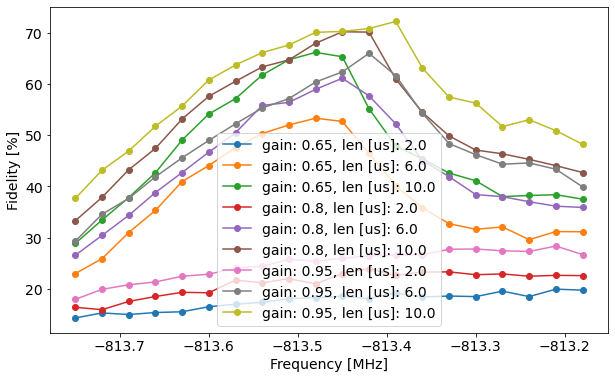

[[[0.14340359 0.23005575 0.28890722]
  [0.16430411 0.26580665 0.33311666]
  [0.17975449 0.29321466 0.37681884]]

 [[0.15325383 0.25906295 0.33450836]
  [0.15955399 0.30445761 0.37875947]
  [0.19925498 0.34580865 0.43176079]]

 [[0.15011126 0.31010775 0.37835946]
  [0.17565439 0.34355859 0.43256081]
  [0.20820521 0.37675942 0.46921173]]

 [[0.15405385 0.35330883 0.42676067]
  [0.18530927 0.38821941 0.47428557]
  [0.21370534 0.41877094 0.51746294]]

 [[0.15550778 0.40966024 0.49059906]
  [0.19345484 0.42721068 0.53166329]
  [0.22480562 0.4559842  0.55696392]]

 [[0.16535413 0.44081102 0.54137707]
  [0.19255481 0.46696167 0.5759144 ]
  [0.22880572 0.48976224 0.60766519]]

 [[0.17036278 0.4759119  0.57137857]
  [0.21730543 0.50476262 0.60521513]
  [0.24071204 0.52222611 0.63713186]]

 [[0.17385435 0.50336258 0.61744631]
  [0.2119053  0.55817791 0.63331583]
  [0.24430611 0.55311383 0.66111653]]

 [[0.18120453 0.520013   0.64733237]
  [0.2201055  0.5640282  0.64696617]
  [0.25770644 0.571414

In [313]:
imax = shotopt.analyze()
shotopt.display()
print(shotopt.data['fid'])

freq_opt = shotopt.data['fpts'][imax[0]]
gain_opt = shotopt.data['gainpts'][imax[1]]
len_opt = shotopt.data['lenpts'][imax[2]]

In [314]:
if save_data: saved_files.append(shotopt.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230217\00000_single_shot_opt_qubit1.h5


## Best readout parameters

In [59]:
shot = meas.HistogramExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_qubit{qubit_i}",
    config_file=config_path,
)
shot.cfg = AttrDict(deepcopy(yaml_cfg))

shot.cfg.expt = dict(
    reps=15000,
    check_f=False,
    qubit=qubit_i,
)

shot.cfg.device.readout.frequency=freq_opt
shot.cfg.device.readout.gain[qubit_i]=gain_opt
# print(freq_opt, gain_opt)
# shot.cfg.device.readout.readout_length = len_opt # [us]

# shot.cfg.device.readout.frequency = -816.25952299
# shot.cfg.device.readout.gain[qubit_i] = 0.025
# shot.cfg.device.readout.readout_length = 2

# shot.cfg.device.readout.frequency=-807.4996158081035
# shot.cfg.device.readout.gain[qubit_i]=0.95
# shot.cfg.device.readout.readout_length = 7 # [us]
# shot.cfg.device.readout.relax_delay = 70 # Wait time between experiments [us]
print(shot.cfg)

shot.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'f_ge': [4125.896624486673, 3452.4896245260456, 4780.416037811193, 4395.282433405918], 'f_ef': [3900.453831863158, 3354.521139701014, 4590.177049031502, 4221.931929269591], 'f_Q1_ZZ': [3449.8479407210834, 0, 3453.9100412763405, 3453.7081320189013], 'f_Q_ZZ1': [4124.290504319941, 0, 4778.502356522805, 4393.211594838028], 'f_EgGf': [2681.44696031, -1, 2028.1, 2407.9], 'f_EgGf_Q': [-1, -1, 5913.75, 5163.75], 'gs': [54.233867058381975, 56.612917931142945, 42.87162116341841, 5.275712018852002, 2.7385639790041876, 6.807578931629736], 'ZZs': [0.0, -5.11947537, -0.14716401, -0.55347891, -5.11803281, 0.0, -1.17332055, -1.13249508, -0.17856354, -1.0686238, 0.0, -0.50772987, -0.64108991, -1.26309732, -0.62827282, 0.0], 'T1': [60, 57, 55, 50], 'pulses': {'pi_ge': {'gain': [29351, 26882, 3021, 2572], 'sigma': [0.015, 0.1, 0.020886833661091352, 0.015], 'type': 'gauss'}, 'pi_ef': {'gain': [20742, 26000, 1633, 1669], 'sigma': [0.015, 0.1, 0.015, 0.015], 'type': 'gauss'}, 'pi_Q1_Z

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

Unrotated:
Ig 177.65289525048797 +/- 38.08373148536095 	 Qg -59.94014313597918 +/- 35.84404795127473 	 Amp g 187.4923250430335
Ie 84.64281067013664 +/- 43.80357597592827 	 Qe -9.547495120364346 +/- 37.58664199219078 	 Amp e 85.17957537587269
Rotated:
Ig -185.18226835071147 +/- 38.08373148536095 	 Qg -31.53195028988302 +/- 35.84404795127473 	 Amp g 187.84764145604427
Ie -77.81115505360216 +/- 43.80357597592827 	 Qe -32.77275879458979 +/- 37.58664199219078 	 Amp e 84.43121205919101


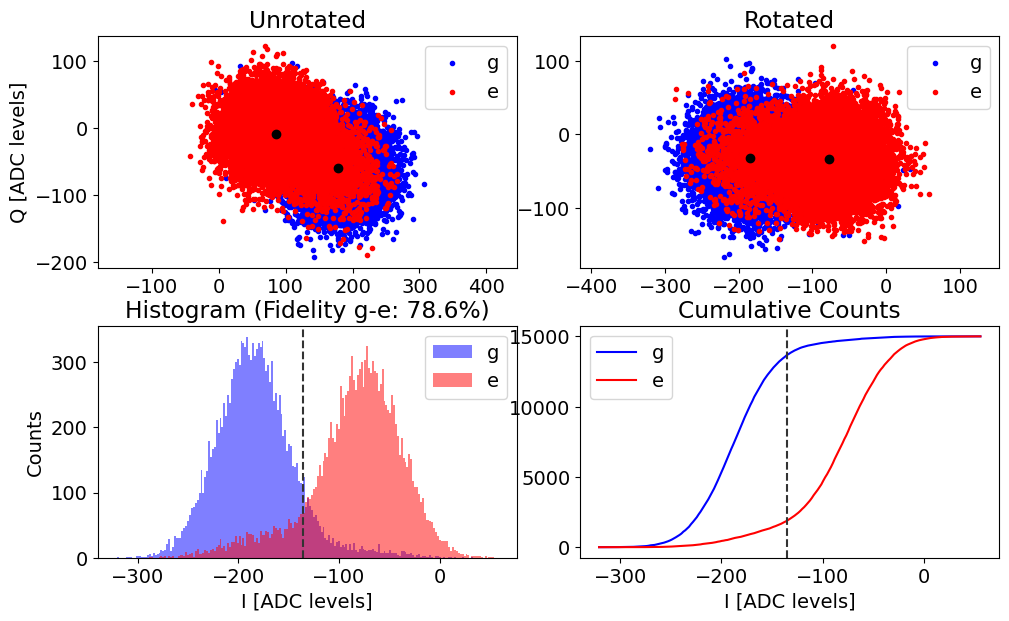

ge fidelity (%): 78.63595453181773
rotation angle (deg): -151.55126801497823
threshold ge: -135.2824215113288


In [60]:
# # TESTING
# shot = meas.HistogramExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00001_single_shot_qubit0.h5')
# data = shot.analyze(data=temp_data)
# shot.display(data=data)

shot.analyze(verbose=False)
shot.display(verbose=True)

In [151]:
if save_data: saved_files.append(shot.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data_221007\00000_single_shot_qubit1.h5


# Results

In [107]:
print(yaml_cfg)
for Qi, results in enumerate(all_results):
    print(f'Qubit {Qi}')
    for key, value in results.items():
        print(f'\t{key}: {value}')
    print()

for saved_file in saved_files:
    print(saved_file)

{'device': {'qubit': {'f_ge': [4126.453954862341, 3454.211606121115, 4780.416037811193, 4395.282433405918], 'f_ef': [3900.453831863158, 3354.521139701014, 4590.177049031502, 4221.931929269591], 'f_Q1_ZZ': [3449.8479407210834, 0, 3453.9100412763405, 3453.7081320189013], 'f_Q_ZZ1': [4124.290504319941, 0, 4778.502356522805, 4393.211594838028], 'f_EgGf': [2681.44696031, -1, 2028.1, 2407.9], 'f_EgGf_Q': [-1, -1, 5913.75, 5163.75], 'gs': [54.233867058381975, 56.612917931142945, 42.87162116341841, 5.275712018852002, 2.7385639790041876, 6.807578931629736], 'ZZs': [0.0, -5.11947537, -0.14716401, -0.55347891, -5.11803281, 0.0, -1.17332055, -1.13249508, -0.17856354, -1.0686238, 0.0, -0.50772987, -0.64108991, -1.26309732, -0.62827282, 0.0], 'T1': [60, 60, 55, 50], 'pulses': {'pi_ge': {'gain': [28871, 26000, 3021, 2572], 'sigma': [0.015, 0.1, 0.020886833661091352, 0.015], 'type': 'gauss'}, 'pi_ef': {'gain': [20742, 26000, 1633, 1669], 'sigma': [0.015, 0.1, 0.015, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ